# 롯데백화점 남/녀 예측분석

롯데백화점 데이터로 남/녀를 구분하는 분류분석을 시행하려 한다. 현 데이터는 남성보다 여성이 더 많은  불균형 데이터이다. 따라서 성별에 따른 특징이 보이는 피쳐를 생성하고자 노력하였다. 피쳐는 크게  5가지 관점(가격, 시간, 장소, 제품, 기타)으로 고객을 파악 및 구분하고자 하였다. 이러한 피쳐들의 유용성을 판단하기 위해서 countplot과 kdeplot을 통한 탐색적 데이터분석을 진행하였다. EDA이후 상관관계가 높은 피쳐들을 확인하였고 이를 일부 제거하여 모든 피쳐끼리 상관관계가 0.7를 넘지않는 최종 피쳐를 생성하였다. 모델링에는 데이터불균형을 해소시키기 위해서 모든 모델에 기본적으로 Stratified KFold을 적용하였다. 튜닝은 랜덤서치와 베이지안 최적화를 이용하여 모델마다 가장 최적화된 파라미터를 찾고자 하였으며 훈련데이터를 모두 활용하고자 train_test_split없이 cross_val_score를 이용하였다. 이렇게 튜닝된 모델로 해본 앙상블의 종류는 3가지로, SoftVoting, Stacking, 그리고 tree기반 모델과 boosting기반 모델의 bestModel을 뽑아서 Seed(3)와 Stratified KFold(4)로 12번의 교차검정을 거친 후 예측값을 앙상블해보았다. 이러한 앙상블 과정 중 새롭게 시도해볼 수 있었던 점은 스태킹에 있어서 메타모델을 베이지안최적화를 통해서 튜닝해보았다는 것과 교차검정을 통한 앙상블이었다. 교차검정을 통한 앙상블은 랜덤서치와 베이지안 최적화를 통해서 튜닝된 20여개의 모델중에서 가장 점수가 잘나온 트리기반의 모델과 부스팅 기반의 모델을 각각 12번의 교차검정을 통해서 predict_proba의 평균을 내었고 이후 트리기반prediction : 부스팅기반prediction을 1 : 2의 비율로 앙상블 하였다. 각 모델마다의 진짜 성능은 제출한 submission의 roc_auc점수를 통해서 알 수 있을 것이다. 그래서 train에 대해서 나온 점수보다는 새롭게 시도하여 본 베이지안 최적화를 통한 메타모델의 점수가 궁금하여 해당 submission을 제출하였다.

 ### process
 
  #### ch.1 Libraries, Read data, Simple Preprocessing
 ***
  #### ch.2 Features (1차 과제 피쳐 그대로)
    - 1. 가격
    - 2. 시간
    - 3. 장소
    - 4. 제품
    - 5. 기타
    - 6. 피쳐 상관관계
 ***
  #### ch.3 modeling
    - Basic models predictions with Stratied KFold
    - Tuned models predictions with Stratied KFold
        - RandomSearch + Stratified KFold
        - BaysianOptimization + Stratified KFold
  #### ch.4 Ensemble
    - RandomSearchCV -> Ensemble: Voting(soft), Stacking
    - BaysianOptimization -> Ensemble: Voting(soft), Stacking
    - Best of bests -> SeedEnsemble + CrossValidation
  ***
    
  #### 비교해볼수 있었던 점:
    - Voting vs Stacking
    - RandomSearchCV vs BaysianOptimization
    - Ensemble vs SeedEnsemble

<br><font color='green'>
## ch.1 Libraries, Read data, Simple Preprocessing

### Libraries

In [222]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

## Read Transactions & Simple Preprocessing

##### Read transactions

In [2]:
X_train = pd.read_csv('tr_train_X.csv', encoding='cp949')
y_train = pd.read_csv('tr_train_y.csv', encoding='cp949')
tr = pd.merge(X_train, y_train, on='cust_id')
tr = tr[['cust_id', 'gender', 'tran_date', 'store_nm','goods_id','gds_grp_nm','gds_grp_mclas_nm','amount']]

##### Simple Preprocessing

In [3]:
## 월, 일, 요일, 계절, (월초, 월중, 월말) 칼럼 추가
tr['month'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).month)
tr['day'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).day)
tr['date'] = tr['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])
tr['season'] = tr['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
tr['month_when'] = tr['day'].agg(lambda x: '0to10' if x in list(range(1,11)) else '11to20' if x in list(range(11,21)) else '21to31')
    

In [4]:
## 가격대 추가
tr['amount_range'] = pd.cut(tr['amount'],
    bins=[-300000000,0, 99999, 199999, 299990, 399990, 499990, 699990,999990, 1999990, 4999990, 800000000 ],
    right = False,
    labels = ['환불금액', '10만원이하', '10만원이상 20만원미만', '20만원이상 30만원미만', '30만원이상 40만원미만', '40만원이상 50만원미만', '50만원이상 70만원미만', '70만원이상 100만원미만', '100만원이상 200만원미만', '200만원이상 500만원미만', '500만원이상'])

<br><font color='green'>
## ch.2 Features

#### 데이터 불균형 확인
 - 각각의 성별을 구분할 수 있도록 하는 피쳐 생성
 - 특히 남성의 수가 적으므로 남성을 구분하는 피쳐일수록 좋음

In [5]:
temp = len(tr.query('gender == 0'))/ len(tr.query('gender == 1'))
print(f'여성의 데이터 수가 남성보다 {temp:.4}배 더 많다.')

여성의 데이터 수가 남성보다 2.642배 더 많다.


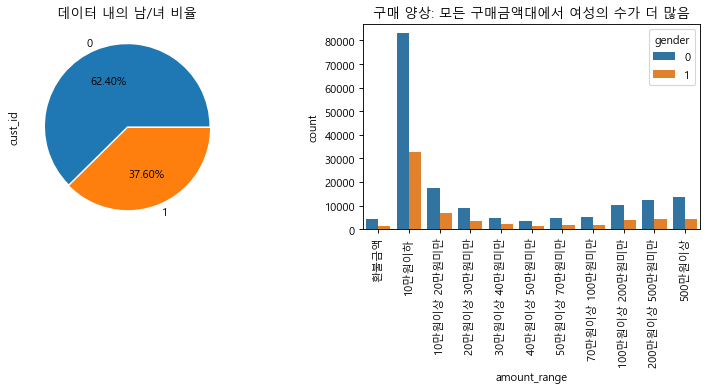

In [6]:
f,ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
tr.groupby('gender')['cust_id'].nunique().plot(kind='pie', autopct='%.2f%%', explode=(0,0.02), ax=ax[0])
ax[0].set_title('데이터 내의 남/녀 비율')
sns.countplot(data=tr, x='amount_range', hue='gender', ax=ax[1])
ax[1].set_title('구매 양상: 모든 구매금액대에서 여성의 수가 더 많음')
for item in ax[1].get_xticklabels():
       item.set_rotation(90)
# plt.axis('equal')
plt.tight_layout()
plt.show()

### 1. 가격적 관점

 만든 피쳐들
   - 년 총 구매금액에 따른 등급, 가격 선호도 
   - 총 구매액,구매건수,최대구매액, 평균 구매액
   - 환불금액, 환불건수, 내점 당 구매액, 구매건수
   

<font color = 'blue'>  롯데백화점 규율에 따른 Vip분류

년 총 구매금액에 따른 등급 (실제 롯데백화점 등급 기준 적용: 2020년도 기준적용)
    
   - 여성 수가 많으므로 전체적인 vip고객들은 여성이 더 높았으나 
   - 확률밀도 함수로 보았을 때 여성은 높은 등급이 많았으나 남성은 주로 낮은 등급이 많으므로 남/녀를 구분할 수 있는 피쳐라 판단됨


 - 실제 롯데백화점 MVG 조건(년간 구매액)
 
 
     - 400만원 이상: Vip -> 200
     - 800만원 이상: Vip+ -> 300
     - 1800~2000만원이상: MVG-Ace  -> 400
     - 4000만원이상: MVG-Crown -> 500
     - 6000만원이상: MVG-Prestige -> 600
     - 1억이상: LENITH -> 700
     - 해당하지 않는 고객들은 silver로 설정 -> 100


In [7]:
# 나누는 함수 정의
def divide_class(x):
    if 4000000<= x < 8000000:
        return 200
    elif 8000000<= x < 18000000:
        return 300
    elif 18000000<= x <40000000:
        return 400
    elif 40000000<= x <60000000:
        return 500
    elif 60000000<= x <100000000:
        return 600
    elif x>= 100000000:
        return 700
    else:
        return 100
    
# vip고객을 구분하는 피쳐 생성 
temp_amountdf = tr.groupby('cust_id')['amount'].sum().reset_index()

temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

f = temp_amountdf[['cust_id', 'class']]

f['gender'] = y_train['gender']

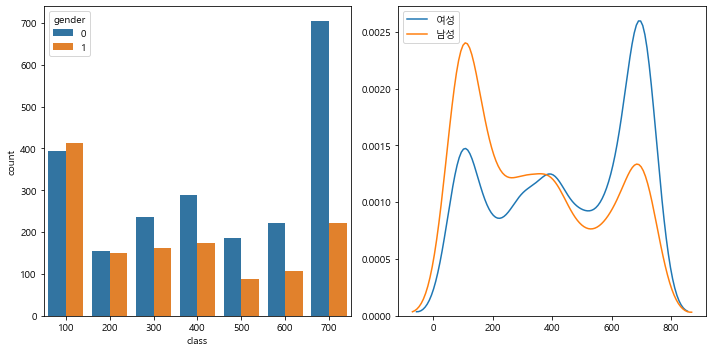

In [8]:
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='class', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['class'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['class'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'> 가격 선호도
    - 고객별 가격 선호도를 생성하여 살펴보았으나 남/녀를 구별할 특징은 보이지 않았다

In [9]:
f = tr.groupby('cust_id')['amount_range'].agg([('prefer_amount', lambda x: x.value_counts().index[0])]).reset_index()

f.prefer_amount = f.prefer_amount.map({'환불금액': 0, '10만원이하': 1, '10만원이상 20만원미만':2, '20만원이상 30만원미만':3,'30만원이상 40만원미만':4, '40만원이상 50만원미만':5, '50만원이상 70만원미만': 6, '70만원이상 100만원미만':7, '100만원이상 200만원미만':8, '200만원이상 500만원미만':9, '500만원이상': 10})

f['gender'] = y_train['gender']

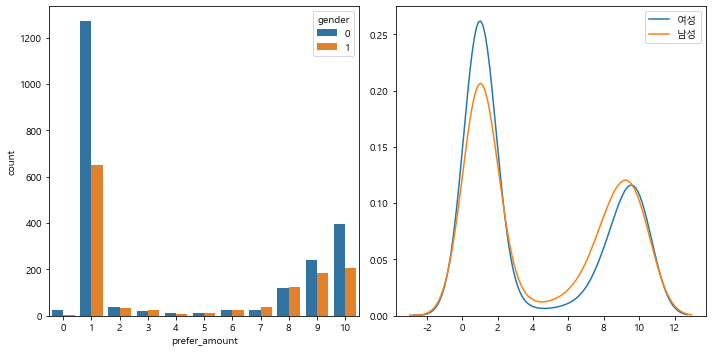

In [10]:
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='prefer_amount', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['prefer_amount'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['prefer_amount'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>총구매액
    
     - 남성이 여성보다 총 구매액은 더 낮은 양상인 것처럼 보인다

In [11]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount',np.sum)]).reset_index()

f['gender'] = y_train['gender']

In [12]:
bins = [i*1000000 for i in range(2325)]
bins2 =  [i*10000000 for i in range(235)]
bins3 =  [i*100000000 for i in range(25)]

f['total_amount_range1'] = pd.cut(f.total_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_range3'] = pd.cut(f.total_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

총구매액을 범주형으로 변환

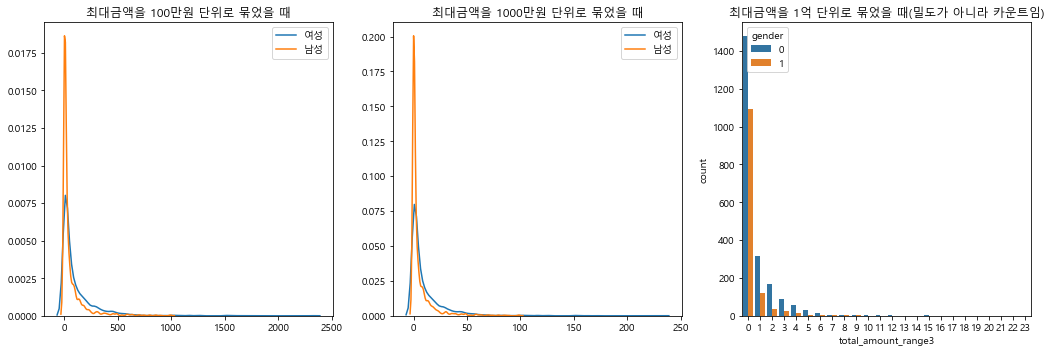

In [13]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_range3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매건수
    - 여성보다 남성들이 더 적은 수의 구매건수를 갖는 경향이 나타나서 남/녀를 구분하기에 적합한 피쳐라 판단함

In [14]:
f = tr.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size)]).reset_index()

f['gender'] = y_train['gender']

구매건수를 범주형 변수로 전환

In [15]:
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]

f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])

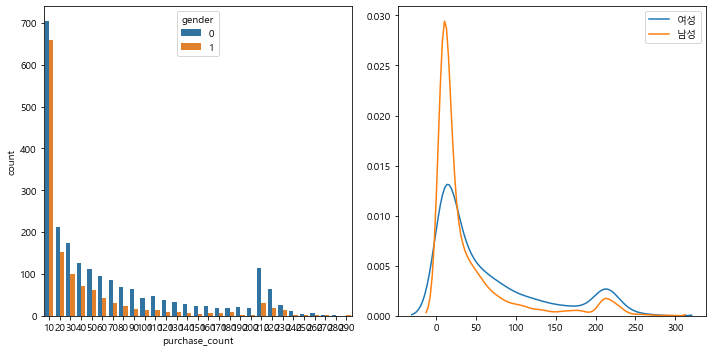

In [16]:
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='purchase_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['purchase_count'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['purchase_count'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'> 최대구매액
    - 최대구매액을 1000만원 단위로 묶었을때 남성이 여성보다 최대구매액이 높다고 판단하여 남/녀 구분 피쳐로 사용.

In [17]:
f = tr.groupby('cust_id')['amount'].agg([ ('max_amount', np.max),]).reset_index()

f['gender'] = y_train['gender']

최대구매액을 범주형으로 변환

In [18]:
bins = [i*1000000 for i in range(710)]
bins2  = [i*10000000 for i in range(71)]

f['max_amount_range1'] = pd.cut(f.max_amount, bins= bins,labels=[i for i in range(1,len(bins))])
f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])

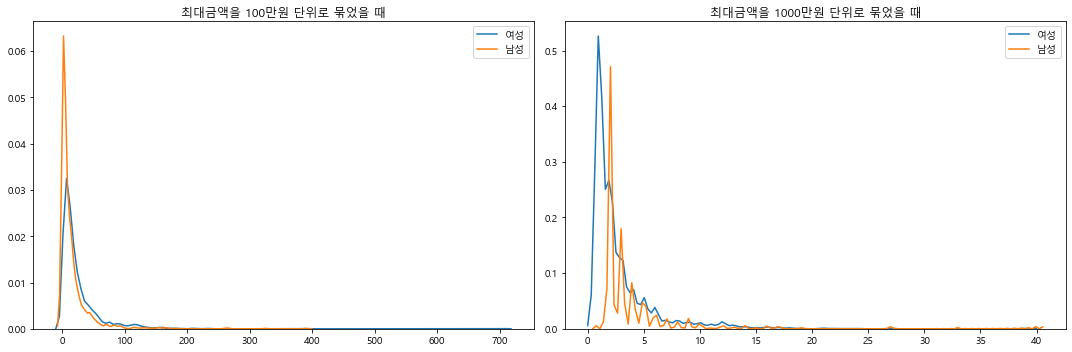

In [19]:
figure, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['max_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['max_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
plt.tight_layout()
plt.show()

<font color = 'blue'>평균구매액
    
    - 10만원 단위에서 다른 단위보다 더욱 다른 양상을 보여서 10만원 단위로 평균구매금액 피쳐를 채택, 카운트는 애매하였음

In [20]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()

f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

f['gender'] = y_train['gender']

거의 대부분 구매자가 평균 구매금액이 서로 다름을 알 수 잇음

In [21]:
f.total_amount_avg.nunique()

3418

In [22]:
bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_avg_range2'] = pd.cut(f.total_amount_avg,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_avg_range3'] = pd.cut(f.total_amount_avg, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

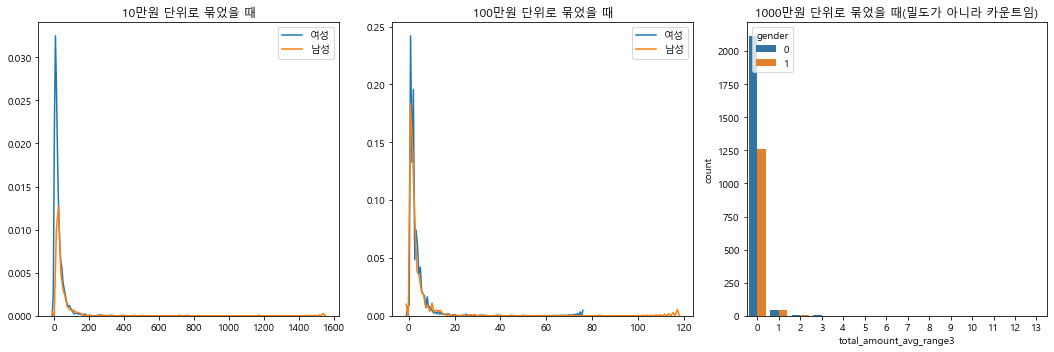

In [23]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_avg_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_avg_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_avg_range3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>총 환불금액
    - 세 단위 모두에서 비슷한 경향을 보이는 것 같아서 피쳐로써 채택하지 않음

In [24]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_amount', lambda x: x.sum() * -1),]).reset_index()

f['gender'] = y_train['gender']

In [25]:
bins = [i*200000 for i in range(4358)]
bins2 =  [i*2000000 for i in range(436)]
bins3 =  [i*20000000 for i in range(44)]

f['refund_amount_range1'] = pd.cut(f.refund_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_amount_range2'] = pd.cut(f.refund_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['refund_amount_range3'] = pd.cut(f.refund_amount, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

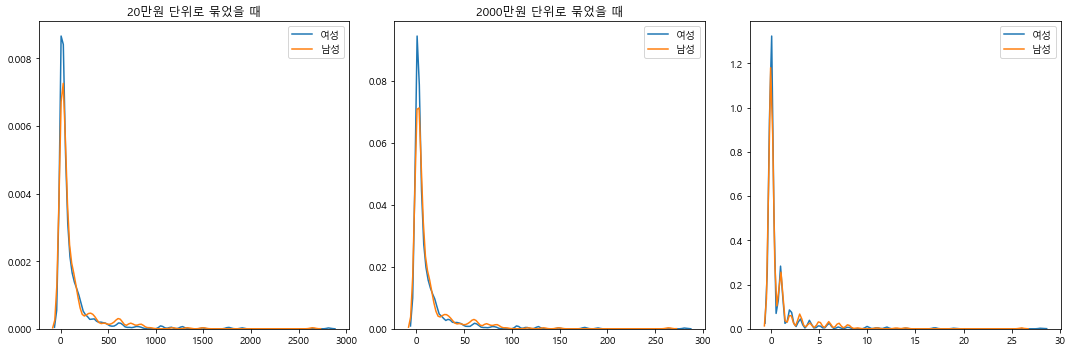

In [26]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['refund_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('20만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('200만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range3'], ax=ax[2], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range3'], ax=ax[2], label='남성')
ax[1].set_title('2000만원 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>환불건수
    - 총 환불금액처럼 환불건수 또한 큰 특징을 보이지 않아 환불과 관련된 피쳐는 모두 제거하기로 함

In [27]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_num', np.size)]).reset_index()

f['gender'] = y_train['gender']

In [28]:
bins = [i for i in range(34)]
bins2 =  [i*2 for i in range(17)]

f['refund_num_1'] = pd.cut(f.refund_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_num_2'] = pd.cut(f.refund_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

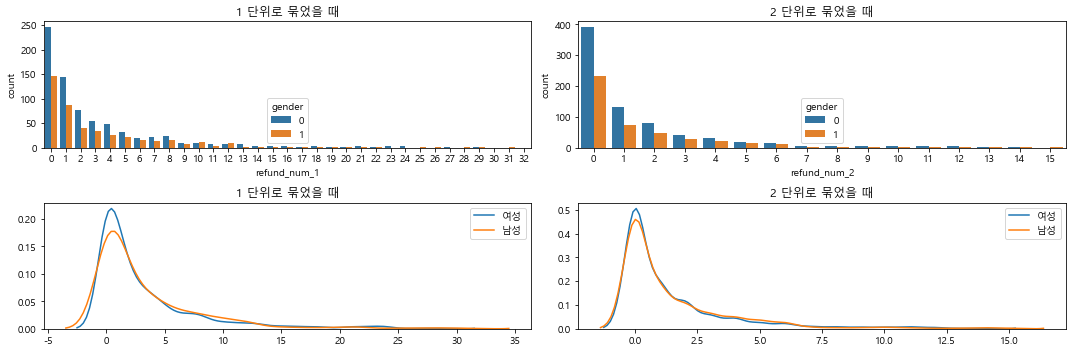

In [29]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='refund_num_1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='refund_num_2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['refund_num_1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_num_2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매금액
    - 내점 당 구매액 = 총구매액 / 내점일수
    - 별 다른 특징을 보이지 않아 피쳐 제거

In [30]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "per_visit_amount"})
f.per_visit_amount = f.per_visit_amount.astype(int)
f['gender'] = y_train['gender']

In [31]:
bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['per_visit_amount1'] = pd.cut(f.per_visit_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_amount2'] = pd.cut(f.per_visit_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per_visit_amount3'] = pd.cut(f.per_visit_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


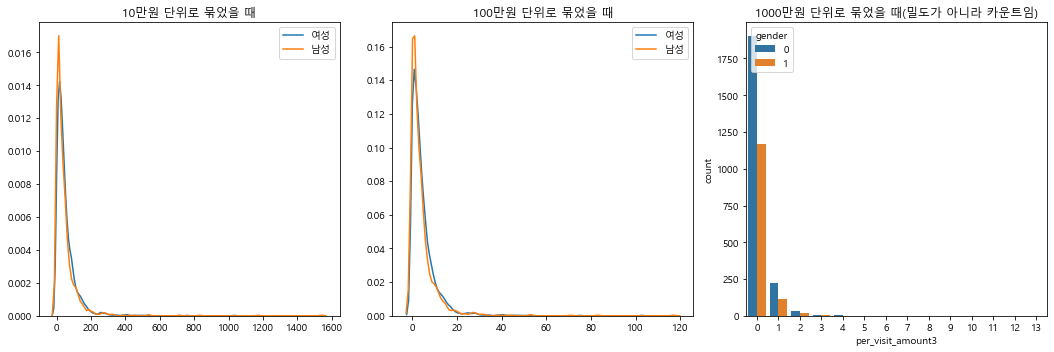

In [32]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per_visit_amount1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_amount2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_amount3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매건수
    
    - 1단위로 보았을 때 남성이 내점당 구매건수가 좀 더 적은 경향을 보여서 피쳐로써 채택

In [33]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수

f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})

f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))

f['gender'] = y_train['gender']

In [34]:
bins = [i for i in range(22)]
bins2 =  [i*2 for i in range(11)]

f['per_visit_pur_num1'] = pd.cut(f.per_visit_pur_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_pur_num2'] = pd.cut(f.per_visit_pur_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

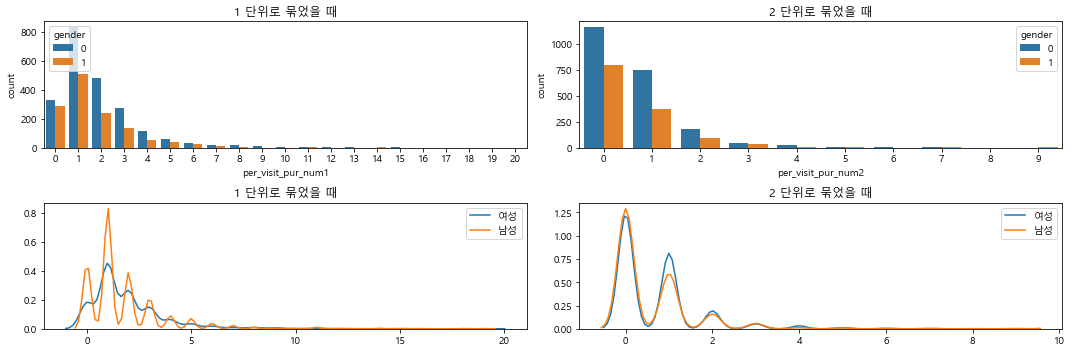

In [35]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='per_visit_pur_num1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_pur_num2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['per_visit_pur_num1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_pur_num2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()


## ────────────────────────────────────────────────────────
### 2. 시간적 관점

 만든 피쳐들
   - 내점일수, 구매주기
   - 선호방문계절, 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)
   - 선호방문월, 방문비율, 구매비율, 구매건수
   - 월초, 월중, 월말 선호 방문때, 방문비율, 구매비율, 구매건수
   - 최근 3개월, 6개월, 12개월 구매금액, 구매건수
   - 선호방문요일, 방문비율, 구매비율, 구매건수
   - 주말방문비율, 고객별 주말구매건수

<font color = 'blue'> 내점일수
    - 1단위 2단위 비슷한 양상으로 남성이 내점일수가 적은 경향을 보임을 알 수 있다.
    - 복잡성 및 과적합을 줄이고자 2단위 피쳐를 채택하기로 하였다

In [36]:
f = tr.groupby('cust_id')['tran_date'].agg([('total_visit',lambda x: x.str[:10].nunique()),]).reset_index()

f['gender'] = y_train['gender']

In [37]:
bins = [i for i in range(285)]
bins2 =  [i*2 for i in range(143)]

f['total_visit1'] = pd.cut(f.total_visit,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

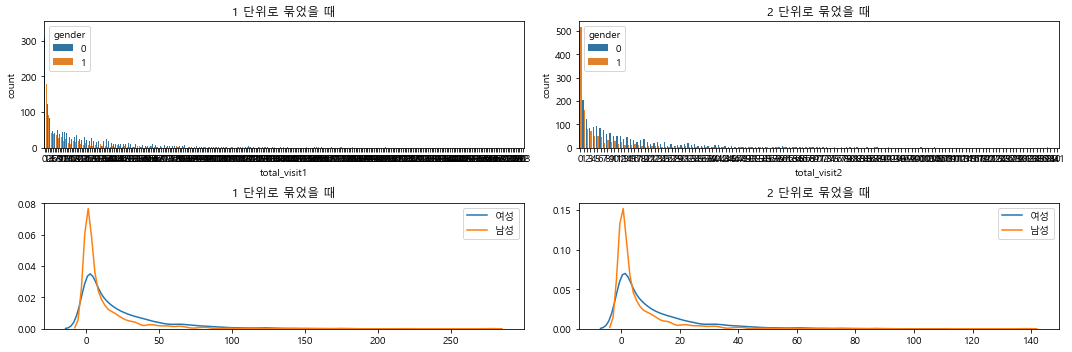

In [38]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='total_visit1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='total_visit2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['total_visit1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_visit2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>구매주기
    - 1단위 2단위 모두 비슷한 양상으로 여성이 구매주기가 짧음을 볼 수 있다
    - 복잡성 및 과적합을 줄이고자 2단위 피쳐를 채택하였다

In [39]:
f = tr.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

f['gender'] = y_train['gender']

In [40]:
f.isnull().sum()

cust_id         0
buying_cycle    0
gender          0
dtype: int64

In [41]:
bins = [i for i in range(166)]
bins2 =  [i*2 for i in range(78)]

f['buying_cycle1'] = pd.cut(f.buying_cycle,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

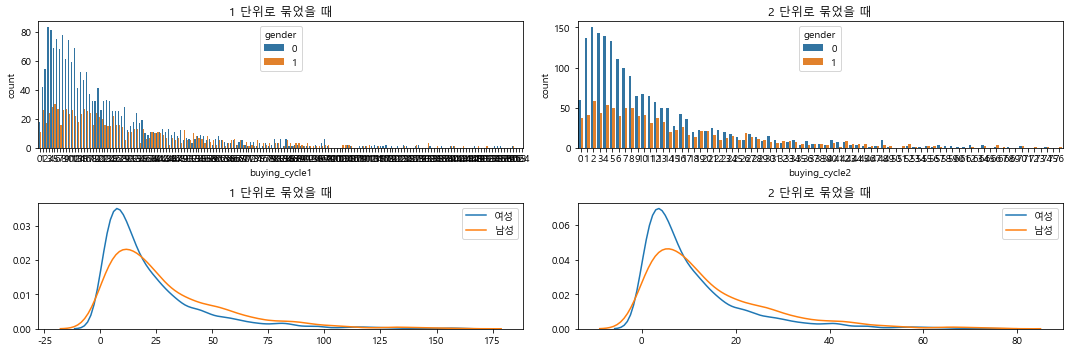

In [42]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='buying_cycle1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='buying_cycle2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['buying_cycle1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['buying_cycle2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문계절(s:3to5, s:6to8, f:9to11, w:12to2)
    
    - 여성은 남성보다 여름이나 가을에 방문하는 것을 선호, 남성은 반대로 봄과 겨울에 방문하는 것을 선호하는 것이 보이므로 채택

In [43]:
## 고객별 선호방문계절
f = tr.groupby('cust_id')['season'].agg([('prefer_season', lambda x: x.value_counts().index[0])]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
f.prefer_season = f.prefer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

f['gender'] = y_train['gender']

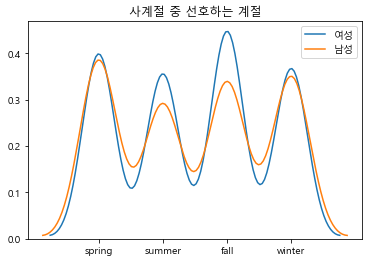

In [44]:
sns.kdeplot(f.query('gender==0').prefer_season, label = '여성')
sns.kdeplot(f.query('gender==1').prefer_season, label = '남성')
plt.xticks([0,1,2,3],['spring','summer','fall','winter'])
plt.title('사계절 중 선호하는 계절')
plt.show()

<font color = 'blue'> 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)
     - 사계절 모두 구매비율이 구별되는 지점이 보이므로 피쳐로 채택

In [45]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()

f['gender'] = y_train['gender']

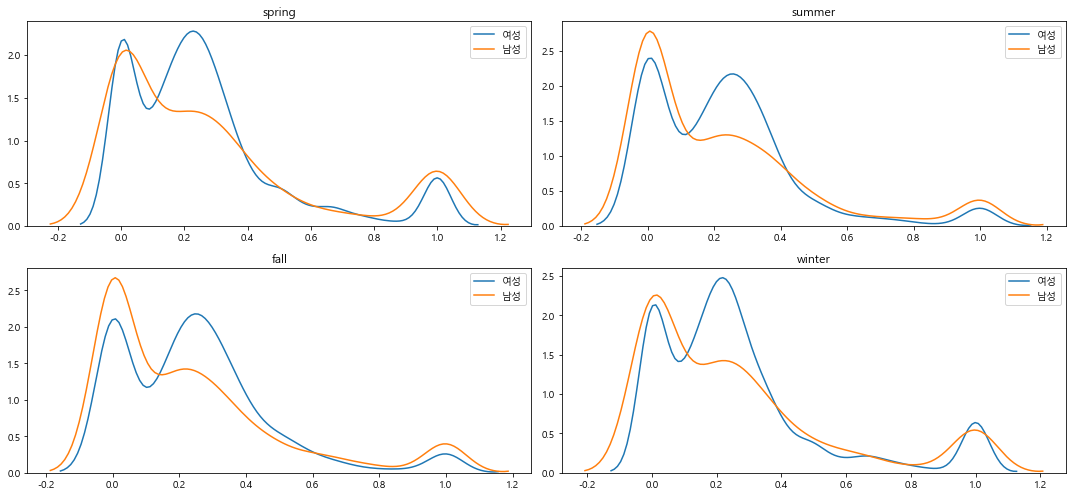

In [46]:
figure, ax = plt.subplots(2, 2, figsize=(15, 7))
sns.kdeplot(f.query('gender==0').spring_pur_ratio, label = '여성', ax=ax[0,0])
sns.kdeplot(f.query('gender==1').spring_pur_ratio, label = '남성', ax=ax[0,0])
ax[0,0].set_title('spring')
ax[0,1].set_title('summer')
sns.kdeplot(f.query('gender==0').summer_pur_ratio, label = '여성', ax=ax[0,1])
sns.kdeplot(f.query('gender==1').summer_pur_ratio, label = '남성', ax=ax[0,1])
ax[1,0].set_title('fall')
sns.kdeplot(f.query('gender==0').fall_pur_ratio, label = '여성', ax=ax[1,0])
sns.kdeplot(f.query('gender==1').fall_pur_ratio, label = '남성', ax=ax[1,0])
ax[1,1].set_title('winter')
sns.kdeplot(f.query('gender==0').winter_pur_ratio, label = '여성', ax=ax[1,1])
sns.kdeplot(f.query('gender==1').winter_pur_ratio, label = '남성', ax=ax[1,1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문월
     - 7월과 8월 사이부터 교차되어서 그 이전에는 남성들이 그 이후에는 여성들이 선호하는 월처럼 보이므로 피쳐로 채택

In [47]:
f = tr.groupby('cust_id')['month'].agg([('prefer_month', lambda x: x.value_counts(1).index[0])]).reset_index()

f['gender'] = y_train['gender']

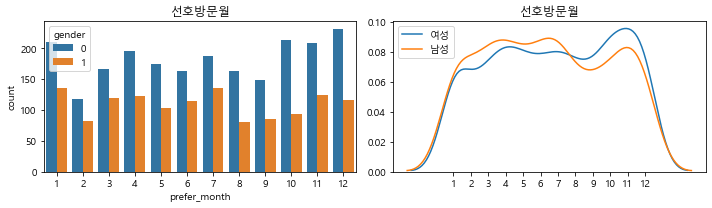

In [48]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month', hue='gender', ax=ax[0])
ax[0].set_title('선호방문월')

sns.kdeplot(f.query('gender==0').prefer_month, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,13)])
plt.title('선호방문월')

plt.tight_layout()
plt.show()

<font color = 'blue'>월별 방문비율
    - 남녀간의 별다른 구분 특징이 보이지 않으므로 피쳐 제거

In [49]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
    
# 월별 방문일수
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

## 고객별 월별 방문비율
for i in range(len(temp_monthpivot.columns)):
    
     temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_visits
    
f = temp_monthpivot.reset_index()

f['gender'] = y_train['gender']


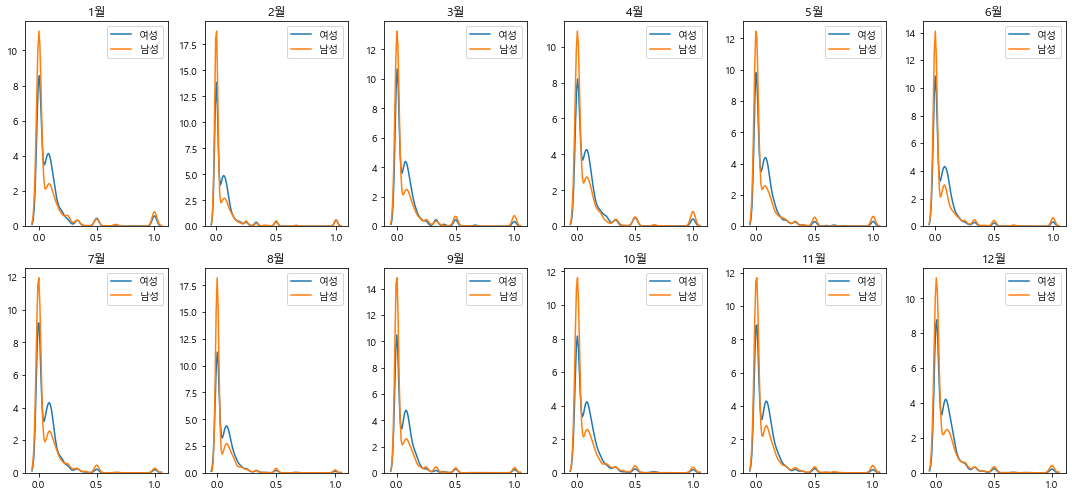

In [50]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>월별  구매비율
    - 12달 중 1월, 2월 그리고 9월을 피쳐로 채택

In [51]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월별 구매금액
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월별 구매금액비율
for i in range(len(temp_monthpivot.columns)):
    
    temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
f = temp_monthpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']


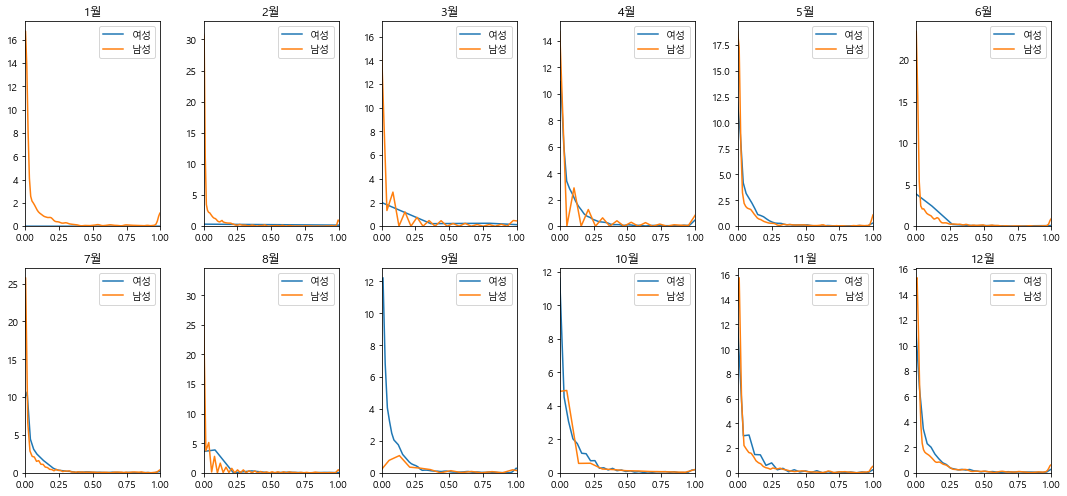

In [52]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_xlim(0,1)
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_xlim(0,1)
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>월별  구매건수
    - 월마다 값이 0에 쏠려 있고 y값을 줄여서 자세히 살펴보니 여성이 전체적으로 남성보다 조금이라도 구매건수가 많지만 큰 차이가 아니므로 피쳐 제거

In [53]:
# 고객별 월별 구매건수
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='amount', aggfunc=np.size, fill_value=0)

f = temp_monthpivot.reset_index()

f['gender'] = y_train['gender']

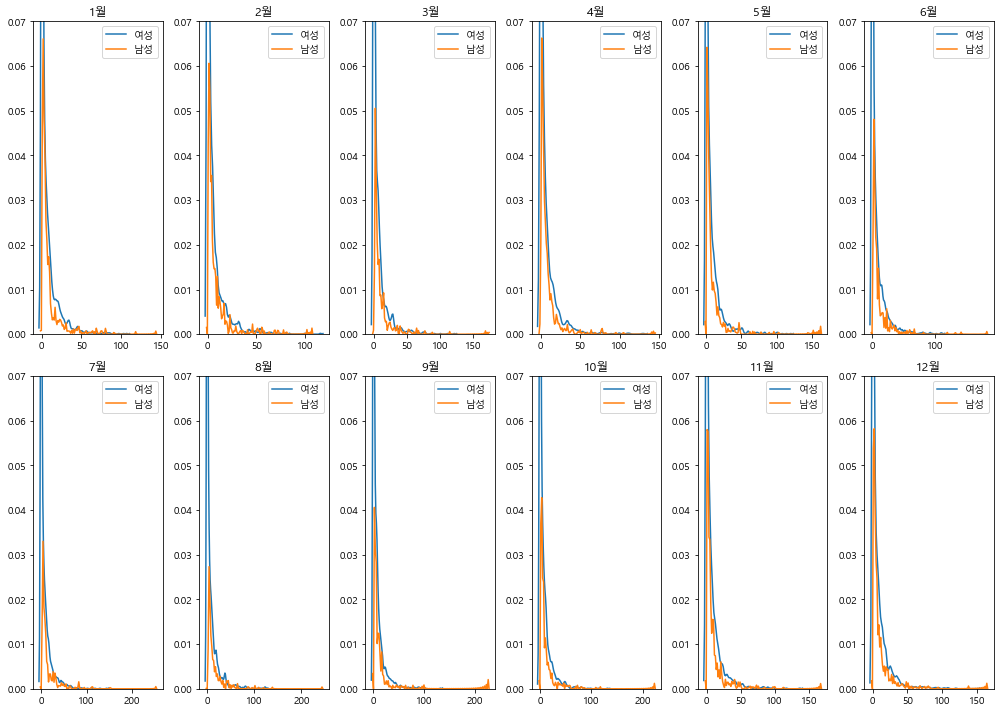

In [54]:
figure, ax = plt.subplots(2, 6, figsize=(14, 10))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_ylim(0,0.07)
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_title(f'{month}월')
    ax[1,temp].set_ylim(0,0.07)
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 선호 방문때
    - 별다른 구분 특징이 보이지 않으므로 피쳐 제거

In [55]:
f = tr.groupby('cust_id')['month_when'].agg([('prefer_month_when', lambda x: x.value_counts().index[0])]).reset_index()

# 문자를 숫자로 바꿔주기: '0to10':0 ~ '21to31': 2
f.prefer_month_when = f.prefer_month_when.map({'0to10':0, '11to20': 1, '21to31':2})

f['gender'] = y_train['gender']

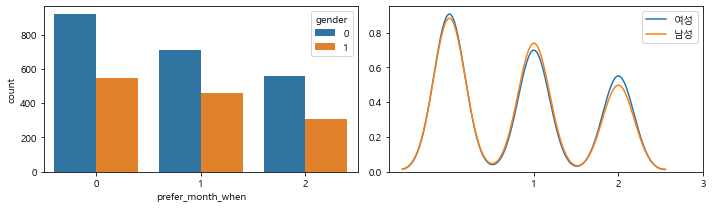

In [56]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month_when', hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0').prefer_month_when, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month_when, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,4)])


plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 방문비율
    
    - 남성과 여성의 방문 비율양상이 다르므로 피쳐로 채택

In [57]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
        
# 고객별 월초, 월중, 월말 방문일수
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 고객별 월초, 월중, 월말 방문비율

for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']


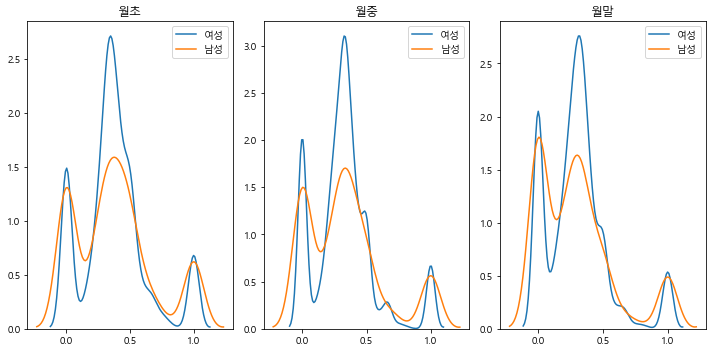

In [58]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매비율
    - 여성과 남성의 구매비율 스펙트럼이 많이 차이나므로 피쳐로 채택

In [59]:
# 고객별 구매금액 총합
total_amount = tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월초, 월중, 월말별 구매금액
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월초, 월중, 월말별 구매금액비율
for i in range(len(temp_monthwhenpivot.columns)):
    
    temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
f = temp_monthwhenpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']

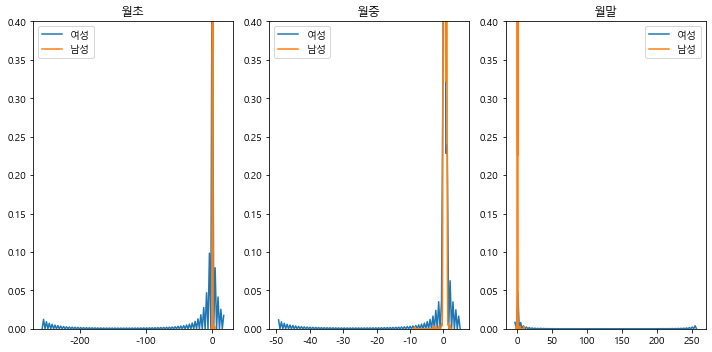

In [60]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
ax[0].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
ax[1].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')
ax[2].set_ylim(0,0.4)
plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매건수
       - 남/녀 양상이 다르므로 피쳐채택

In [61]:
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)

f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']

In [62]:
bins = [i*10 for i in range(57)]
bins2 = [i*10 for i in range(65)]
bins3 = [i*10 for i in range(67)]
labels = [i for i in range(len(bins)-1)]
labels2 = [i for i in range(len(bins2)-1)]
labels3 = [i for i in range(len(bins3)-1)]
f['0to10_10unit'] = pd.cut(f['0to10'], bins=bins, labels = labels)
f['11to20_20unit'] = pd.cut(f['11to20'], bins=bins2, labels = labels2)
f['21to31_30unit'] = pd.cut(f['21to31'], bins=bins3, labels = labels3)

f = f.fillna(0)

In [63]:
f

month_when,cust_id,0to10,11to20,21to31,gender,0to10_10unit,11to20_20unit,21to31_30unit
0,0,33,28,13,0,3,2,1
1,1,0,0,3,0,0,0,0
2,2,4,0,0,1,0,0,0
3,3,18,11,15,1,1,1,1
4,4,0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...
3495,3495,0,0,2,1,0,0,0
3496,3496,6,7,0,1,0,0,0
3497,3497,1,0,0,0,0,0,0
3498,3498,1,1,0,0,0,0,0


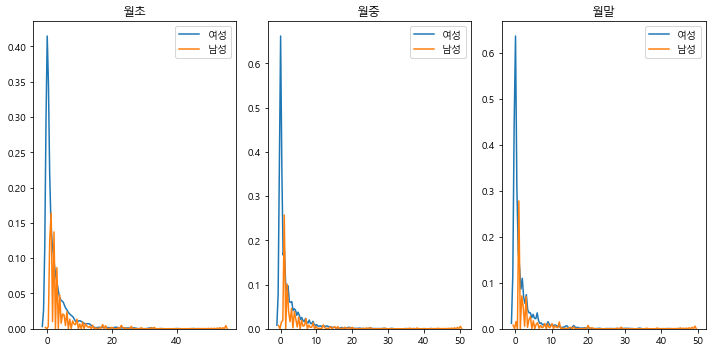

In [64]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5)) 
sns.kdeplot(f.query('gender==0')['0to10_10unit'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10_10unit'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20_20unit'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20_20unit'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31_30unit'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31_30unit'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매금액
    - 남/녀에서 별 다른 차이가 보이지 않으므로 피쳐제거
    - 6개월에서도 비슷하여서 6개월도 피쳐제거


In [65]:
start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(3))
f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
    ('per3month_amount_ratio', np.sum), 
    ('per3month_num_of_pur', np.size)
]).reset_index()

f['gender'] = y_train['gender']

In [66]:
bins1 = [i*1000000 for i in range(762)]
bins2 =  [i*10000000 for i in range(77)]
bins3 =  [i*100000000 for i in range(8)]

f['per3month_amount_ratio1'] = pd.cut(f.per3month_amount_ratio, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_amount_ratio2'] = pd.cut(f.per3month_amount_ratio, bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per3month_amount_ratio3'] = pd.cut(f.per3month_amount_ratio, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

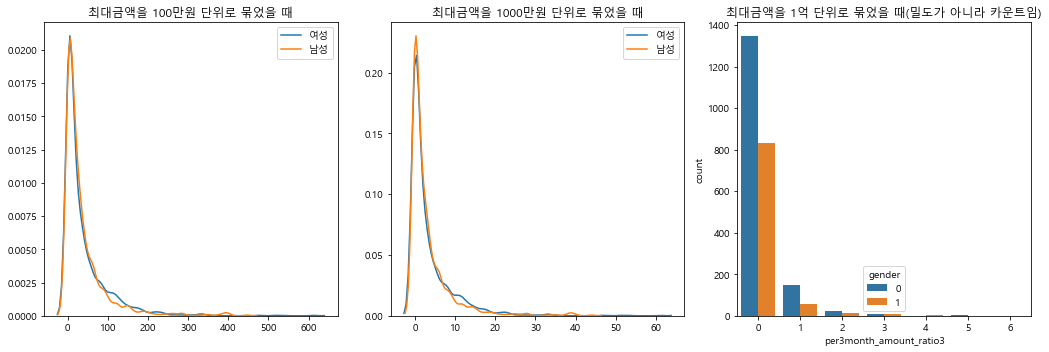

In [67]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='per3month_amount_ratio3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매건수
    - 4단위에 걸쳐서 보았음에도 차별된 특징이 보이지 않아 피쳐제거
    - 6개월에서도 비슷하여서 6개월도 피쳐제거

In [68]:
bins1 = [i for i in range(528)]
bins2 = [i*2 for i in range(265)]
bins3 = [i*4 for i in range(133)]
bins4 = [i*5 for i in range(106)]

f['per3month_num_of_pur1'] = pd.cut(f.per3month_num_of_pur, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_num_of_pur2'] = pd.cut(f.per3month_num_of_pur, bins= bins2,labels=[i*2 for i in range(0,len(bins2)-1)])
f['per3month_num_of_pur3'] = pd.cut(f.per3month_num_of_pur, bins= bins3,labels=[i*4 for i in range(0,len(bins3)-1)])
f['per3month_num_of_pur4'] = pd.cut(f.per3month_num_of_pur, bins= bins4,labels=[i*5 for i in range(0,len(bins4)-1)])

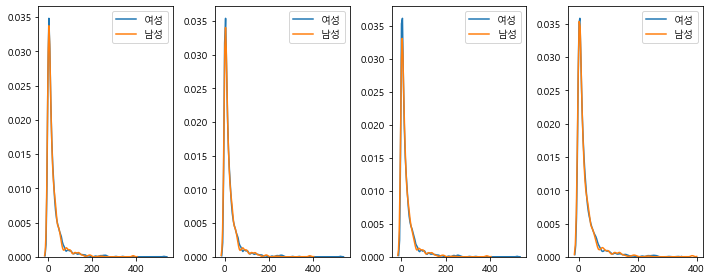

In [69]:
figure, ax = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
    sns.kdeplot(f.query('gender==0')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='여성')
    sns.kdeplot(f.query('gender==1')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='남성')

    
plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 12개월 구매금액, 구매건수
    - 앞에서 다룬 총 구매 금액과 총 구매건수와 겹치므로 피쳐제거

<font color = 'blue'> 선호방문요일
    - 요일에 따른 남/녀 차이가 보이므로 피쳐로 채택

In [70]:
f = tr.groupby('cust_id')['date'].agg([('prefer_date', lambda x: x.value_counts().index[0])]).reset_index()

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f['gender'] = y_train['gender']

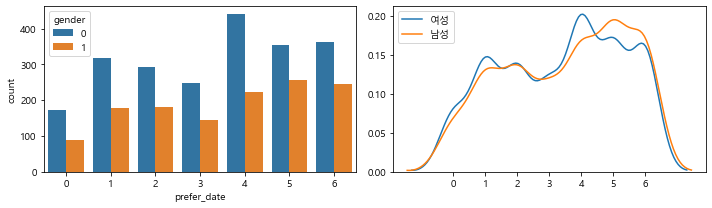

In [71]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='prefer_date', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').prefer_date, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_date, label = '남성', ax=ax[1])
plt.xticks([i for i in range(7)])

plt.tight_layout()
plt.show()

<font color = 'blue'> 방문비율
    - 여성이 방문비율이 대체적으로 높은 모습이다. 일요일을 제외하고 월~토요일을 피쳐로 채택

In [72]:
 # 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()

# 고객별 요일별 방문일수
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 방문비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
f = temp_datepivot.reset_index()
f['gender'] = y_train['gender']

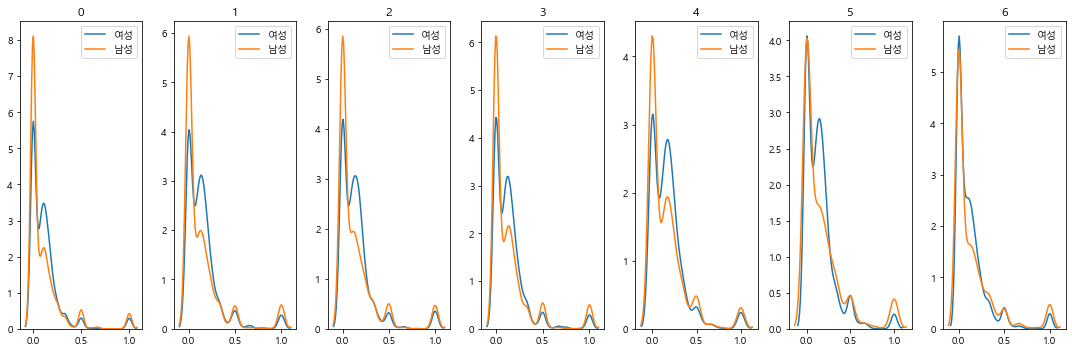

In [73]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율
    - 요일과 구매비율에 따른 스펙트럼 차이가 많이 나므로 피쳐로 채택

In [74]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 요일별구매금액
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 구매금액비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
f = temp_datepivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
f['gender'] = y_train['gender']

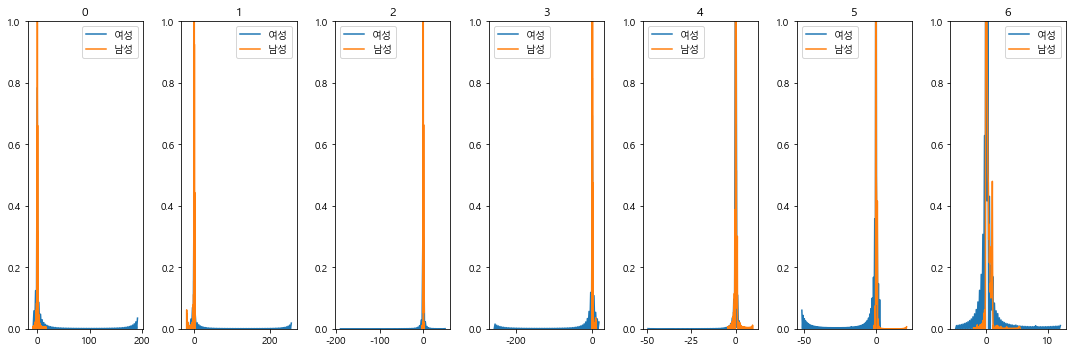

In [75]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
    ax[date].set_ylim(0,1)

plt.tight_layout()
plt.show()

<font color = 'blue'>구매건수
    - 여성이 구매건수가 남성보다 조금더 많으며 요일마다 다른 양상을 보이므로 피쳐로 채택

In [76]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f = temp_datepivot.reset_index()

f['gender'] = y_train['gender']

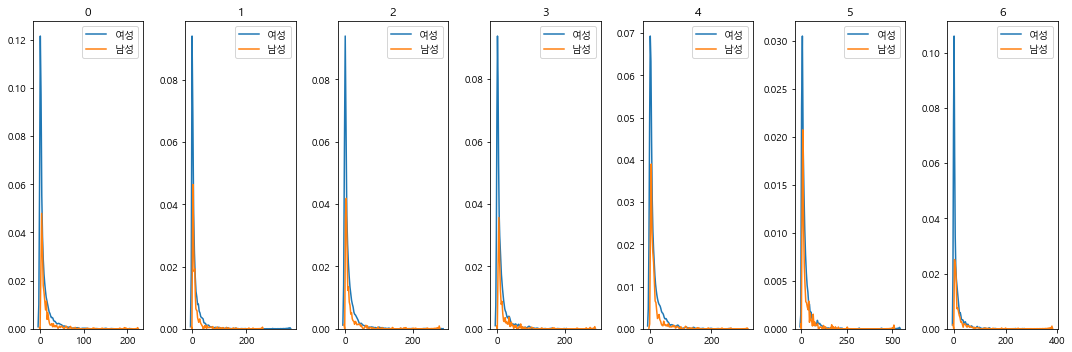

In [77]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
plt.tight_layout()
plt.show()

<font color = 'blue'> 주말방문비율
    - 남성이 여성보다 주말방문비율이 더 높은 것으로 보인다 피쳐 채택

In [78]:
f = tr.groupby('cust_id')['tran_date'].agg([('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))]).reset_index()

f['gender'] = y_train['gender']

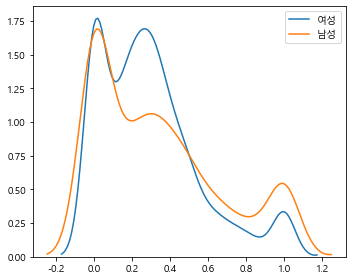

In [79]:
plt.figure(figsize= (5,4))
sns.kdeplot(f.query('gender==0').weekend_visit_ratio, label = '여성')
sns.kdeplot(f.query('gender==1').weekend_visit_ratio, label = '남성')

plt.tight_layout()
plt.show()

<font color = 'blue'> 주말구매건수
    - 여성이 남성보다 주말구매건수가 더 많은 것으로 보인다

In [80]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})

f['gender'] = y_train['gender']

In [81]:
bins2 =  [i*10 for i in range(63)]
f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f.weekend_buy2 = f.weekend_buy2.fillna(0)

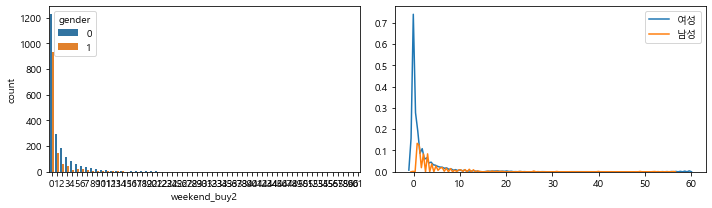

In [82]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='weekend_buy2', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').weekend_buy2, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').weekend_buy2, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 3. 장소적 관점

만든 피쳐들
   - 주구매지점
   - 방문 지점의 수
   - 많이 방문한 지점들 best-12 순위별 구매금액비율, 구매건수

<font color = 'blue'> 주구매지점
    - 남성과 여성을 주구매지점으로 구분하기에는 데이터뿐만아니라 그래프적 정보도 부족한것 같아서 피쳐 제거

In [83]:
f = tr.groupby('cust_id')['store_nm'].agg([('main_store', lambda x: x.value_counts().index[0])]).reset_index()

# 지점명 숫자로 바꿔주기
store_name = tr.store_nm.unique().tolist()
store_newname = [i for i in range(len(store_name))]
f.main_store = f.main_store.map(dict(zip(store_name, store_newname)))

f['gender'] = y_train['gender']

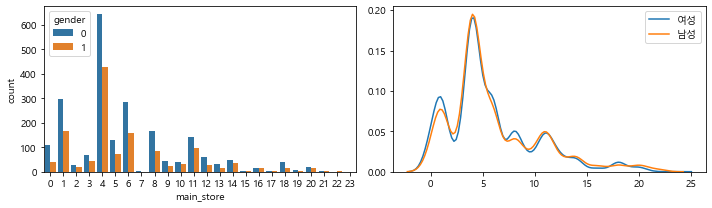

In [84]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='main_store', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_store, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_store, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 방문 지점의 수
    - 방문 지점수가 남성은 1이 여성보다 높지만 여성은 2와 3에서 남성보다 높다.  큰 차이의 비율차는 아니지만 여성이 남성보다 방문 지점의 수가 더 많다

In [85]:
f = tr.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

f['gender'] = y_train['gender']

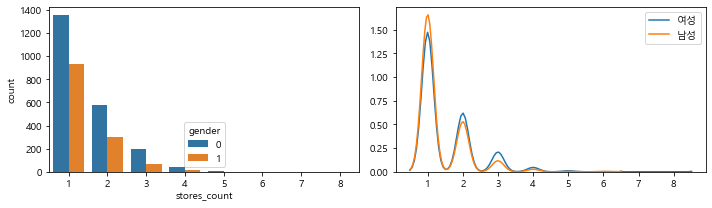

In [86]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='stores_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').stores_count, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').stores_count, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 방문비율
    - 각 지점마다 그림과 같이 방문데이터는 여성이 많아도 남성들이 해당 지점마다 확률비율이 다르므로 피쳐로 채택
    - 방문 지점마다 모두 그림을 그리고 싶었지만 kdeplot의 선택된 kde가 bandwidth가 0인 것들이 있어서 대표적으로 하나만 그렸다

 - top-12가 전체 24개의 점포중 91% 데이터를 차지한다

In [87]:
## 전체의 90프로를 넘게 차지하는 12개의 점포 데이터

print(tr.store_nm.value_counts()[:12].sum() / tr.store_nm.value_counts().sum())

0.9145704384407165


In [88]:
## top-12에 해당하는 지점들
    
top12store = tr.store_nm.value_counts()[:12].index.tolist()

print(top12store)

['본  점', '분당점', '잠실점', '부산본점', '일산점', '노원점', '광주점', '영등포점', '강남점', '부평점', '청량리점', '대전점']


In [89]:
# 고객별 전체방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
# 고객별 점포별 방문일수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_department' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 방문비율
for i in range(len(temp_storepivot.columns)):
    
     temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

In [90]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(12):
    
    f[f'{i}_department{i}'] = pd.cut(f[f'{i*10}_department'], bins= bins, labels = labels)

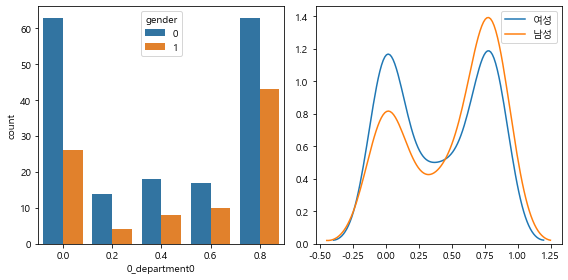

In [91]:
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_department0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_department0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_department0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매금액비율
    - 각 지점마다 그림과 같이 구매데이터는 여성이 많아도 남성들이 더 높은 구매금액비율을 보일때도 있고 밀도함수의 그래프도 지점마다 다르므로 피쳐로 채택
    - 방문 지점마다 모두 그림을 그리고 싶었지만 kdeplot의 선택된 kde가 bandwidth가 0인 것들이 있어서 대표적으로 하나만 그렸다

In [92]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 점포별 구매금액
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 구매금액비율
for i in range(len(temp_storepivot.columns)):
    
    temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

In [93]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(12):
    
    f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)

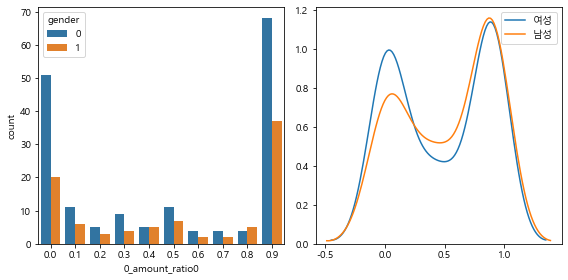

In [94]:
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_amount_ratio0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_amount_ratio0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_amount_ratio0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매건수
    - 구매건수를 5단위, 10단위로 묶어보았을 때 5단위가 좀더 완만하면서 남/녀 그래프 차이가 좀 더 나아서 5단위로 채택하였다

In [95]:
# 고객별 점포별 구매건수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=np.size, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_num_of_pur' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

In [96]:
bins1 = [i*5 for i in range(195)]
bins2 = [i*10 for i in range(98)]
labels1 = [i for i in range(194)]
labels2 = [i for i in range(97)]
f[f'0_num_of_pur1'] = pd.cut(f['0_num_of_pur'], bins= bins1, labels = labels1)
f[f'0_num_of_pur2'] = pd.cut(f['0_num_of_pur'], bins= bins2, labels = labels2)

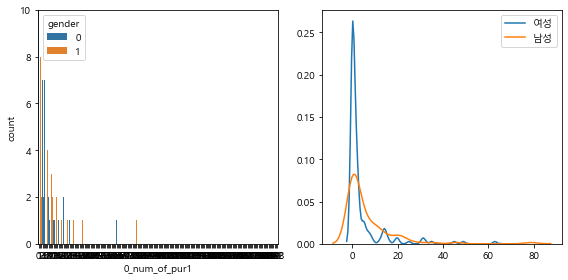

In [97]:
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_num_of_pur1'], hue='gender', ax=ax[0])
ax[0].set_ylim(0, 10)
sns.kdeplot(f.query('gender==0')['0_num_of_pur1'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_num_of_pur1'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 4.  제품적 관점

   - 구매추세 패턴
        - 주구매 상품1: goods_id
        - 주구매 상품2: gds_grp_nm
        - 주구매 상품3: gds_grp_mclas_nm
   - 상품별 구매순서 -> 가장 먼저 방문하는 상품대분류명군
   - 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)
   - Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
   - 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수비율(3471 중 x)
   - 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)
   - 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

<font color = 'blue'> 구매추세패턴

<font color = 'blue'> 주구매상품1

주구매 상품: 고객별 가장 많이 구매한 상품(goods_id)
     - 총 3471개 물품 중 3500명 고객이 각자 가장 많이 사는 물품들은 850개정도로 겹치는 물품들이 존재하였다
     - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [98]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('main_product_goods', lambda x: x.value_counts().index[0])
]).reset_index()

str_name = f.main_product_goods.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_goods = f.main_product_goods.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

print('고객들이 많이 구매하는 제품 goods_id 수: ', f.main_product_goods.nunique())

고객들이 많이 구매하는 제품 goods_id 수:  846


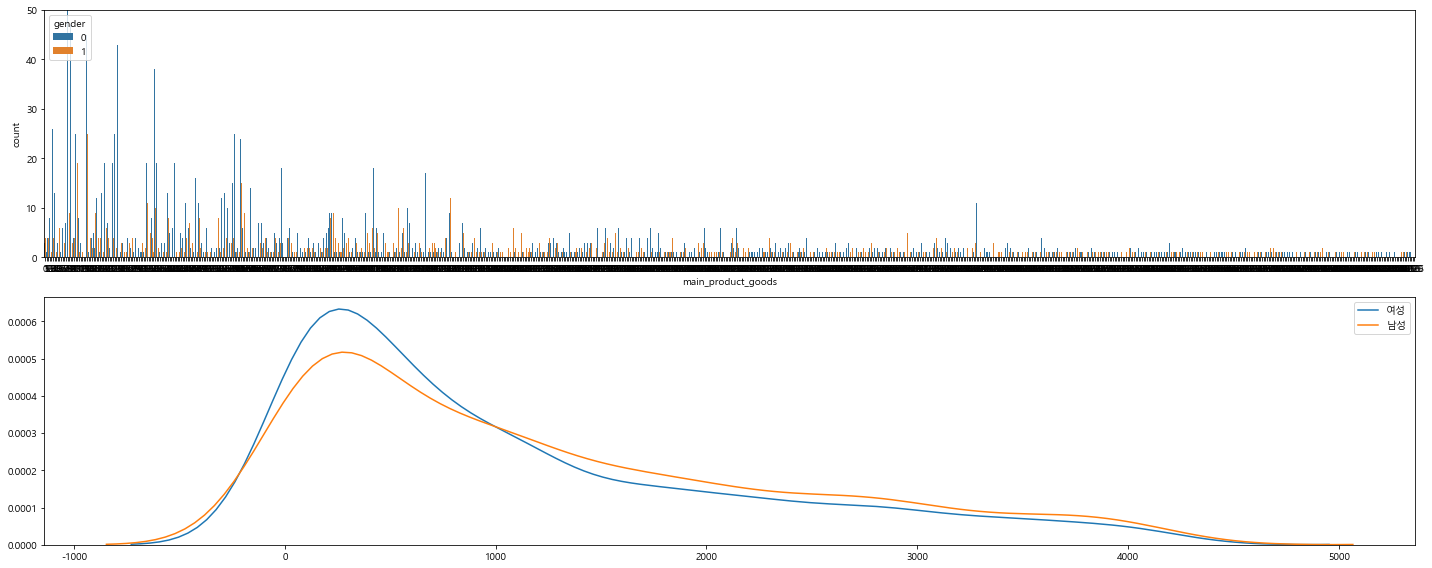

In [99]:
figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_goods', hue='gender', ax=ax[0])
ax[0].set_ylim(0,50)
sns.kdeplot(f.query('gender==0').main_product_goods, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_goods, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품2
    - 총 324개 중 203개로 겹치는 gds_grp_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [100]:
f = tr.groupby('cust_id')['gds_grp_nm'].agg([('main_product_nm', lambda x: x.value_counts().index[0])]).reset_index()

str_name = f.main_product_nm.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

print('고객들이 많이 구매하는 제품 gds_grp_nm 수: ', f.main_product_nm.nunique())

고객들이 많이 구매하는 제품 gds_grp_nm 수:  191


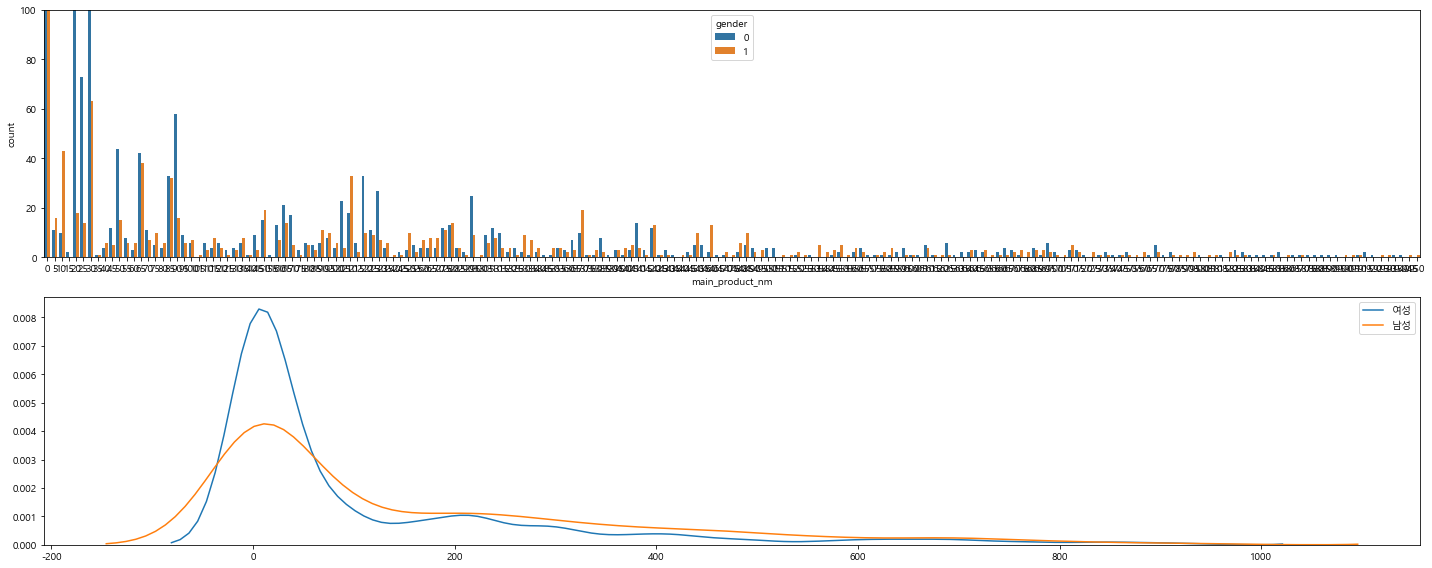

In [101]:
figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_nm', hue='gender', ax=ax[0])
ax[0].set_ylim(0,100)
sns.kdeplot(f.query('gender==0').main_product_nm, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_nm, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품3
    - 총 49개 중 42개로 겹치는 gds_grp_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [102]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([('main_product_mclas', lambda x: x.value_counts().index[0])]).reset_index()

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.main_product_mclas.unique().tolist()
num_name = [i*10 for i in range(len(str_name))]
f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

print('고객들이 많이 구매하는 제품 gds_grp_mclas_nm 수: ', f.main_product_mclas.nunique())

고객들이 많이 구매하는 제품 gds_grp_mclas_nm 수:  43


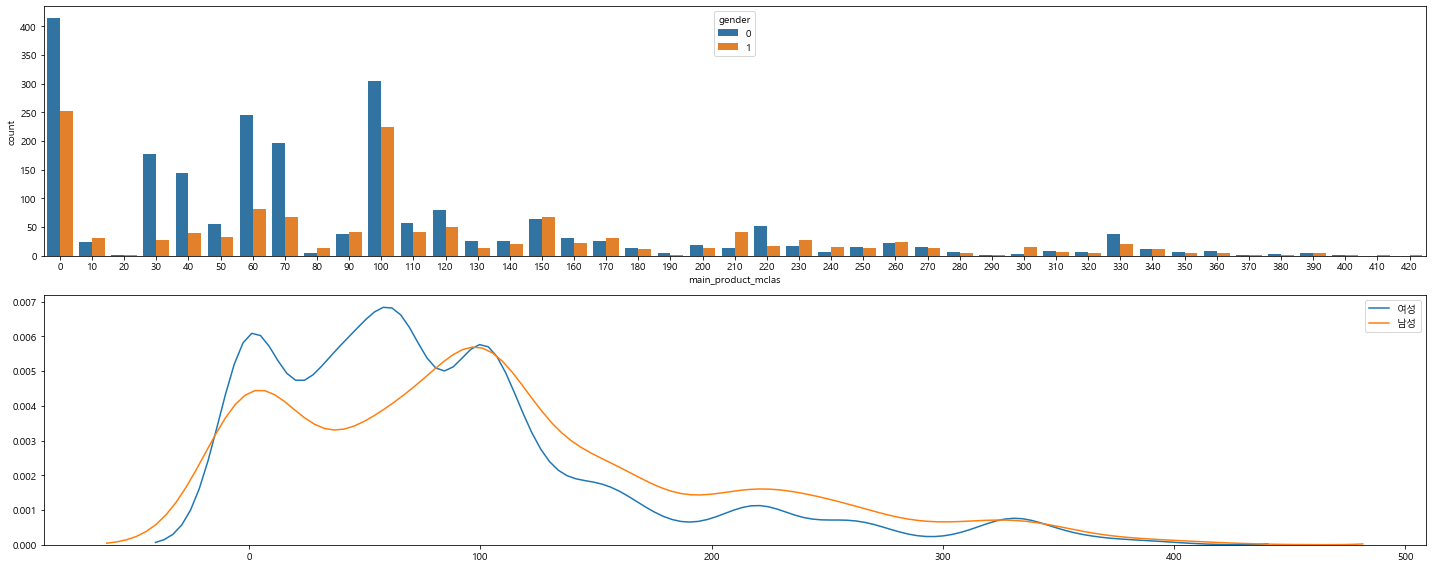

In [103]:
figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_mclas', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_product_mclas, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_mclas, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 상품별 구매순서
    - 고객이 가장 먼저 찾아가는 gds_grp_mclas_nm 를 보았다.
    - 일단 피쳐로써 채택하지만 위의 주구매순서의 gds_grp_mclas_nm와의 상관관계 정도를 살펴보고 차후 제거될 수 있다

In [104]:
temp_lst = []
for i in range(3500):
    temp_lst.append(tr.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500)})
f['first_visit_place'] = temp_lst

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

In [105]:
f.first_visit_place.nunique()

45

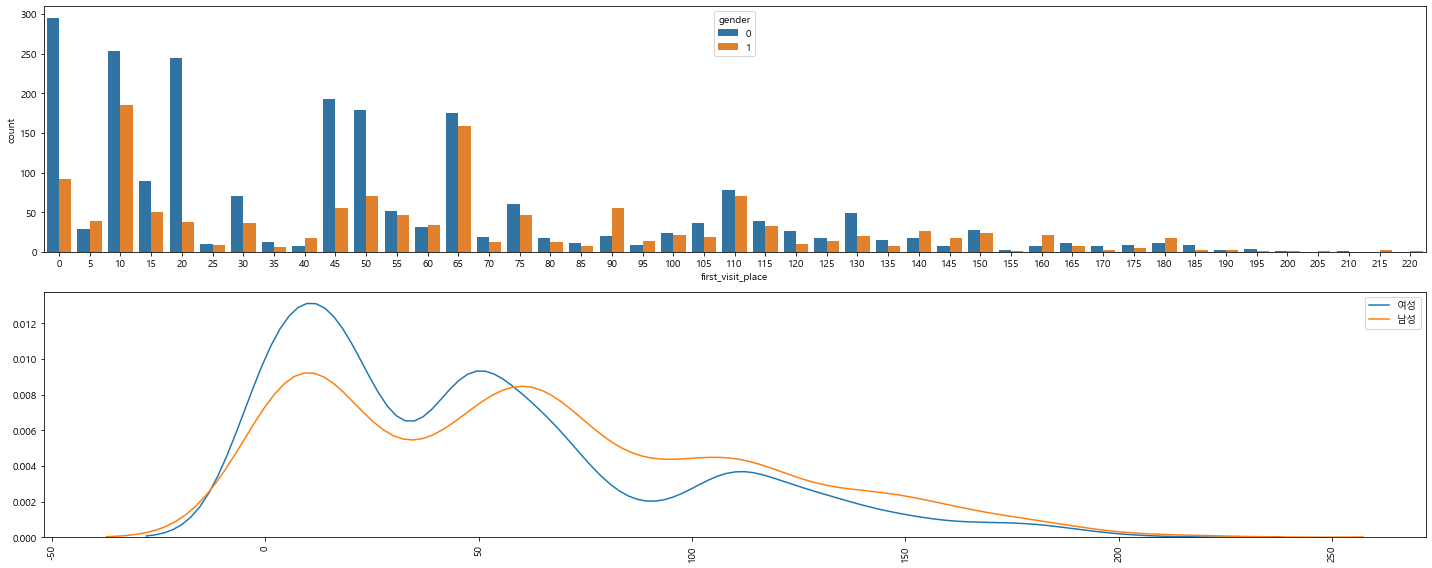

In [106]:
figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='first_visit_place', hue='gender', ax=ax[0])
plt.xticks(rotation=90)
sns.kdeplot(f.query('gender==0').first_visit_place, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').first_visit_place, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)
    - 대체적으로 여성들의 구매종류수가 더 많음을 알 수 있다 피쳐로 채택
    - 하지만 나중에 피쳐간의 상관관계를 볼때 만약 너무 높다면 이중에 하나만 채택한다

In [107]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('num_pur_type1', lambda x: x.nunique())],
    'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()

f['gender'] = y_train['gender']

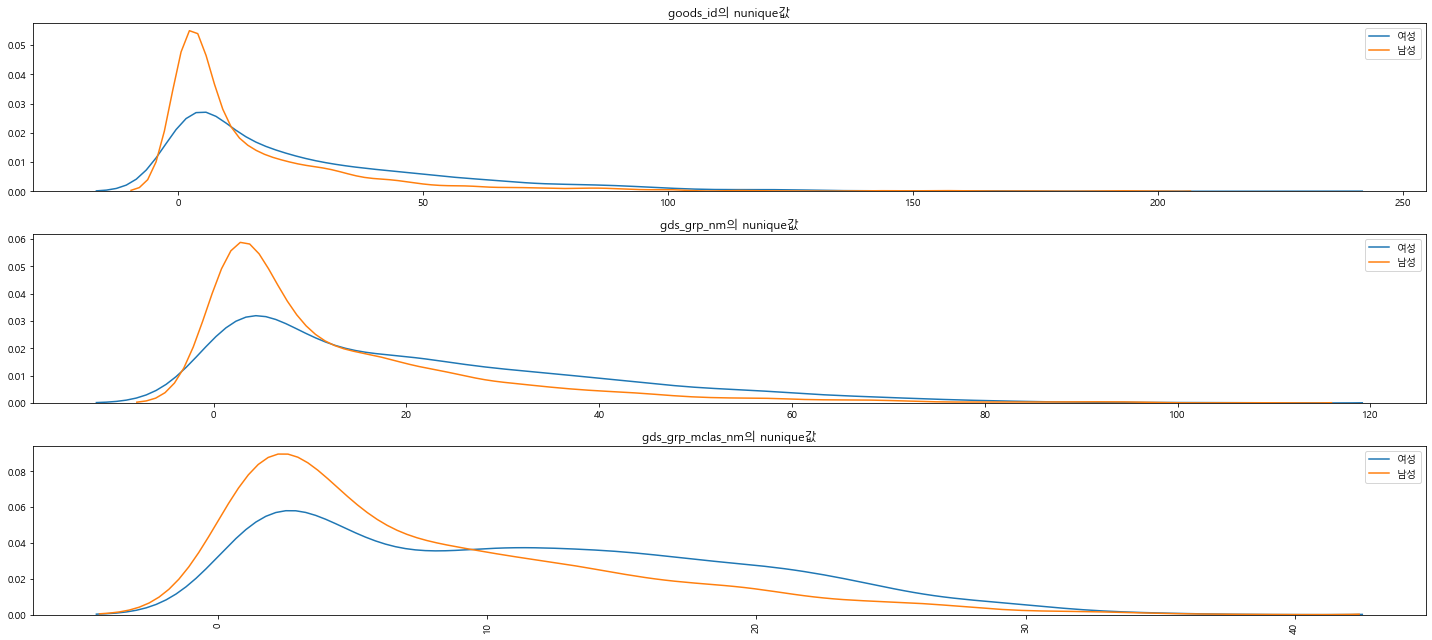

In [108]:
figure , ax = plt.subplots(3, 1, figsize=(20,9))

for i in range(3):
    sns.kdeplot(f.query('gender==0')[f'num_pur_type{i+1}'], label='여성', ax=ax[i])
    sns.kdeplot(f.query('gender==1')[f'num_pur_type{i+1}'], label='남성', ax=ax[i])
ax[0].set_title('goods_id의 nunique값')
ax[1].set_title('gds_grp_nm의 nunique값')
ax[2].set_title('gds_grp_mclas_nm의 nunique값')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 상품 분류별  top-x 구매금액비율 , 구매건수
 - 상품분류별 중 90퍼센트 이상을 차지하는 상품들의 구매금액비율과 구매건수를 구한다
 - 주구매상품에서 상품대분류, 중분류, 소분류에서 모두 차이가 났기 때문에 구체적으로 상품별로 구분하고자 생성하였다
 - 나중에 train과 test에서 겹치는 부분을 뽑아내기 때문에 칼럼 수가 줄어든다.
        - goods_id(상품소분류별) top550 구매금액비율, 구매건수
        - gds_grp_nm(상품중분류별) top75 구매금액비율, 구매건수
        - gds_grp_mclas_nm(상품대분류별) top25 구매금액비율, 구매건수

<font color = 'blue'> 많이 구매한 상품소분류별 best-x 구매금액비율,  구매건수(3471 중 x)

In [109]:
total = tr.amount.sum()

## 전체 구매금액 중 goods_id top550이 전체의 90퍼센트 정도를 차지한다.

top550 = tr.groupby('goods_id')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:550]

top550sum = top550['amount'].sum()

top550goods = top550['goods_id'].tolist()

print(top550sum / total)

0.9034186144204891


In [110]:
totalsum = tr.groupby('cust_id')['amount'].sum()

temp_goodsdf = tr.query('goods_id in @top550goods')
    
## top550goods 구매금액비율    
temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=sum, fill_value=0)
    
for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

f = temp_goodspivot.reset_index()


## top550goods 구매금액건수

temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 변수명이 겹치는 것을 막기 위해서 변수명을 다르게 바꿔주는 과정
oldname = temp_goodspivot.columns.tolist()
newname = [(str(i)+'_buy') for i in oldname]
temp_goodspivot = temp_goodspivot.rename(columns = dict(zip(oldname, newname)))

f2 = temp_goodspivot.reset_index() # 3258행
f = pd.merge(f, f2, how='outer').fillna(0)


<font color = 'blue'> 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)

In [111]:
## 전체 구매금액
total = tr.amount.sum()

## 전체 구매금액 중 gds_grp_nm top75이 전체의 90퍼센트 정도를 차지한다.

top75 = tr.groupby('gds_grp_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:75]

top75sum = top75['amount'].sum()

top75goods = top75['gds_grp_nm'].tolist()

print(top75sum / total)

0.9099637919037719


In [112]:
# 고객별 전체 구매금액
totalsum = tr.groupby('cust_id')['amount'].sum()

## top75goods 구매금액비율
temp_goodsdf = tr.query('gds_grp_nm in @top75goods')

temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=sum, fill_value=0)

# 변수명 영문화
kor_name = temp_goodspivot.columns.tolist()
newname = [str(i*3)+'grp_nm' for i in range(len(kor_name))]
temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))    
    
for i in range(len(temp_goodspivot.columns)):
    temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

f = temp_goodspivot.reset_index()


## top75goods 구매금액건수

temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=np.size, fill_value=0)

# 변수명 영문화
kor_name = temp_goodspivot.columns.tolist()
newname = [str(i*3)+'grp_nm_buy' for i in range(len(kor_name))]
temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))  

f2 = temp_goodspivot.reset_index()


<font color = 'blue'> 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

In [113]:
## 전체 구매금액
total = tr.amount.sum()

## 전체 구매금액 중 gds_grp_mclas_nm top25이 전체의 90퍼센트 정도를 차지한다.
top25 = tr.groupby('gds_grp_mclas_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:25]
    
top25sum = top25['amount'].sum()
    
top25goods = top25['gds_grp_mclas_nm'].tolist()

print(top25sum / total)

0.9232754143371885


In [114]:
 # 고객별 전체 구매금액
totalsum = tr.groupby('cust_id')['amount'].sum()
    
## intersection25 구매금액비율
temp_goodsdf = tr.query('gds_grp_mclas_nm in @top25goods')

temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=sum, fill_value=0)

# 변수명 영문화
kor_name = temp_goodspivot.columns.tolist()
newname = [str(i*3)+'mclas_nm' for i in range(len(kor_name))]
temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))   
    
for i in range(len(temp_goodspivot.columns)):
    temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

f = temp_goodspivot.reset_index()

## intersection25 구매건수

temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=np.size, fill_value=0)

# 변수명 영문화
kor_name = temp_goodspivot.columns.tolist()
newname = [str(i*3)+'mclas_nm_buy' for i in range(len(kor_name))]
temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname))) 

f2 = temp_goodspivot.reset_index()

## ────────────────────────────────────────────────────────

### 5.  기타적 관점

<font color = 'blue'> 휴면(또는 이탈) 여부
    - 여성과 남성 모두 데이터량이 비슷하였으며 주관적 생각에 의해 휴면고객이라 생각된 사람들 중에서 남/녀를 구별할 수 없었으므로 피쳐 제거

 * 롯데백화점에서 휴면회원은 일년이상 이용하지 않은 고객이다
 * 하지만 데이터가 2007년만 있으니, 일년동안 방문이 2번이하인 사람들이 휴면 또는 이탈여부가 있다고 보고 1 그렇지 않은 사람들을 0 으로.
      -  3번이상 5번이하의 고객들은 띄엄띄엄 방문하는 경향이 있었으며 주기도 10개월이하로 단골은 아니지만 이탈위험이 크게 느껴지진 않았다.(주관)

In [115]:
## 총 방문일수가 2일 이하인 고객들
f = tr.groupby('cust_id')['tran_date'].nunique().reset_index().query('tran_date in [1, 2]')

f['leave_risk'] = [5 for i in range(len(f.tran_date))]

f = f[['cust_id', 'leave_risk']]

f['gender'] = y_train['gender']

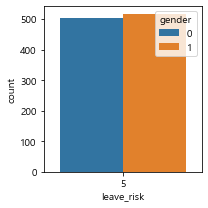

In [116]:
plt.figure(figsize=(3,3))
sns.countplot(data=f, x='leave_risk', hue='gender')

plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 6.  피쳐 상관관계

<font color = 'blue'> EDA 이후 채택되지 않은 피쳐들 제거

가격: 가격 선호도, 환불금액, 환불건수, 내점 당 구매액,      
시간: 월별 방문비율, 월별 구매건수, 월초, 월중, 월말 선호 방문때, 최근 3개월, 6개월, 12개월 구매금&구매건수   
장소: 주구매지점   
제품: Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부(겹쳐서)   
기타: 휴면(또는 이탈)여부 

In [117]:
df = pd.read_csv('X_train_after_eda.csv', encoding='cp949')

<font color = 'blue'> 같은 관점의 피쳐끼리 상관관계
    - 같은 관점끼리 히트맵을 그려 상관관계가 0.7이상인 칼럼들을 모두 제거하였다
    - 밑의 히트맵은 상관관계가 높았던 칼럼들의 제거 이후에 그린 히트맵이다

상관관계가 0.7이상으로 높아서 삭제한 칼럼들   


가격: none   
시간: 월초, 월중, 월말 구매건수&구매비율, 요일별 구매건수, 주말 구매건수, 1월 구매비율, 수목금 구매비율   
장소: top12 방문비율   
제품: 소중대분류에서 상관관계 높은 상품 162개   
기타: none


In [118]:
df = pd.read_csv('X_train_after_eda.csv', encoding='cp949')

In [119]:
high_corr_cols = []

delCol1 = ['0to10_10unit', '11to20_20unit', '21to31_30unit','4_buy', '3_buy', '2_buy','0_buy','6_buy','5_buy','1_buy','weekend_buy2', '1_month_amount','2_month_amount','0to10_amount','0to10_amount','11to20_20unit','21to31_amount','3_amount','2_amount','4_amount']

delCol2 = ['0_visits0','1_visits1','2_visits2','3_visits3','4_visits4','5_visits5','6_visits6','7_visits7','8_visits8','9_visits9','10_visits10']

delCol3 = ['num_pur_type2', 'num_pur_type3']

delCol4 = ['241192', '262241', '263107', '542166', '740195', '742196', '241125_buy', '241133_buy', '241192_buy', '262141_buy', '262241_buy', '263107_buy', '342111_buy', '342132_buy', '562128_buy', '563196_buy', '740195_buy', '742196_buy', '96grp_nm_buy', '141grp_nm_buy', '165grp_nm_buy', '189grp_nm_buy', '195grp_nm_buy', '18mclas_nm_buy', '48mclas_nm_buy', '63mclas_nm_buy', '56108', '607138', '811110', '66123_buy', '77152_buy', '303126_buy', '321103_buy', '542192_buy', '607138_buy', '39grp_nm', '45grp_nm', '192grp_nm', '12grp_nm_buy', '15grp_nm_buy', '36grp_nm_buy', '45grp_nm_buy', '111grp_nm_buy', '3mclas_nm', '15mclas_nm', '15mclas_nm_buy', '21mclas_nm_buy', '45mclas_nm_buy', '26165', '66123', '68273', '73119', '125156', '127118', '127128', '127131', '127141', '128128', '128131', '173197', '204125', '204128', '204152', '204162', '206101', '208102', '208110', '208121', '208140', '222102', '245105', '245117', '245140', '261188', '275131','303125', '303140', '321106', '322103', '322154', '322158', '331101', '342150', '361106', '361206', '365219', '530157', '530232', '541153', '542266', '552110', '562117', '562132', '563112', '611150', '611162', '611189', '613151', '624165', '630134', '647101','663102', '663106', '663108', '663110', '663111', '735105', '735124', '737101', '740112', '740120', '740130', '740131', '740153', '740177', '740178', '740215', '808194', '811115', '811127', '811156', '813150', '823165', '37140_buy', '56108_buy', '73151_buy', '127109_buy', '262161_buy', '303109_buy', '303110_buy', '303146_buy', '303209_buy', '303246_buy', '322111_buy', '322211_buy', '562113_buy', '611150_buy', '618101_buy', '647101_buy', '663106_buy', '731196_buy', '735124_buy', '9grp_nm', '42grp_nm', '54grp_nm', '72grp_nm', '78grp_nm', '93grp_nm', '135grp_nm', '198grp_nm', '42grp_nm_buy', '54grp_nm_buy', '72grp_nm_buy', '78grp_nm_buy', '93grp_nm_buy', '108grp_nm_buy', '117grp_nm_buy', '135grp_nm_buy', '138grp_nm_buy', '171grp_nm_buy', '192grp_nm_buy', '198grp_nm_buy']

high_corr_cols = delCol1 + delCol2 + delCol3 + delCol4

print('1차 상관관계 높은 칼럼 제거 개수: ', len(high_corr_cols))

df2 = df.drop(columns=high_corr_cols)

1차 상관관계 높은 칼럼 제거 개수:  195


In [120]:
df = df.drop('cust_id', axis=1)

price_df = df.iloc[:, :6]

time_df = df.loc[:,'total_visit2':'weekend_buy2']
time_df = time_df.drop(columns=delCol1)

store_df = df.loc[:,'stores_count':'10_num_of_pur10']
store_df = store_df.drop(columns=delCol2)

product_df = df.loc[:,'main_product_goods':'num_pur_type3']
product_df = product_df.drop(columns=delCol3)

product_df2 = df.loc[:,'num_pur_type3':]
product_df2 = product_df2.drop(columns=delCol4)

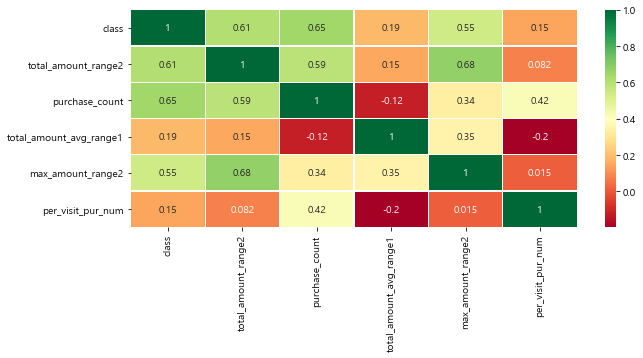

In [121]:
plt.figure(figsize=(10,4))
sns.heatmap(price_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

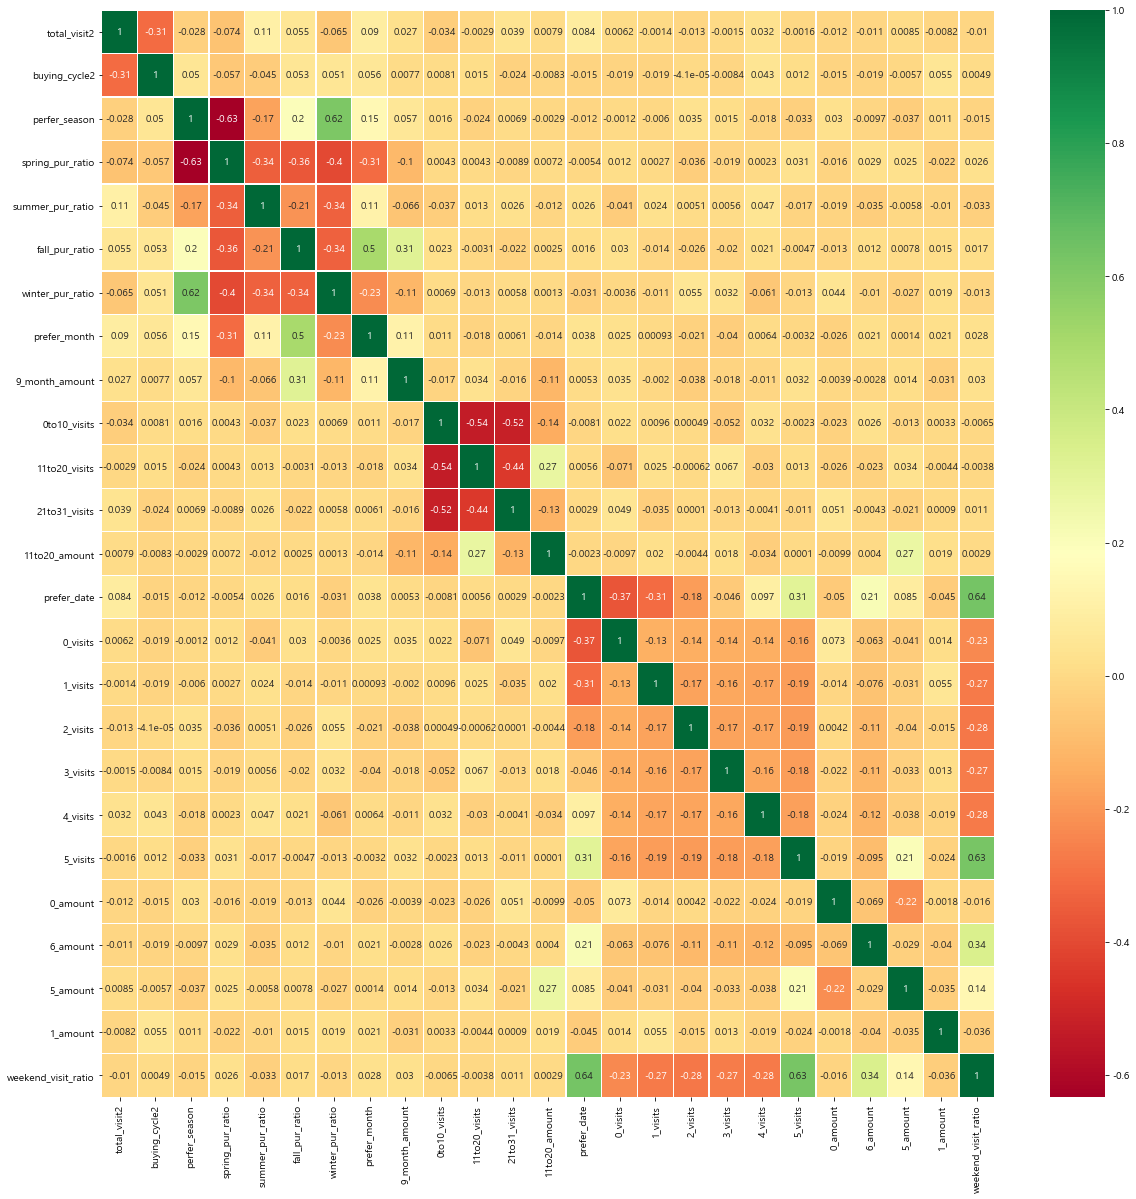

In [122]:
plt.figure(figsize=(20,20))
sns.heatmap(time_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

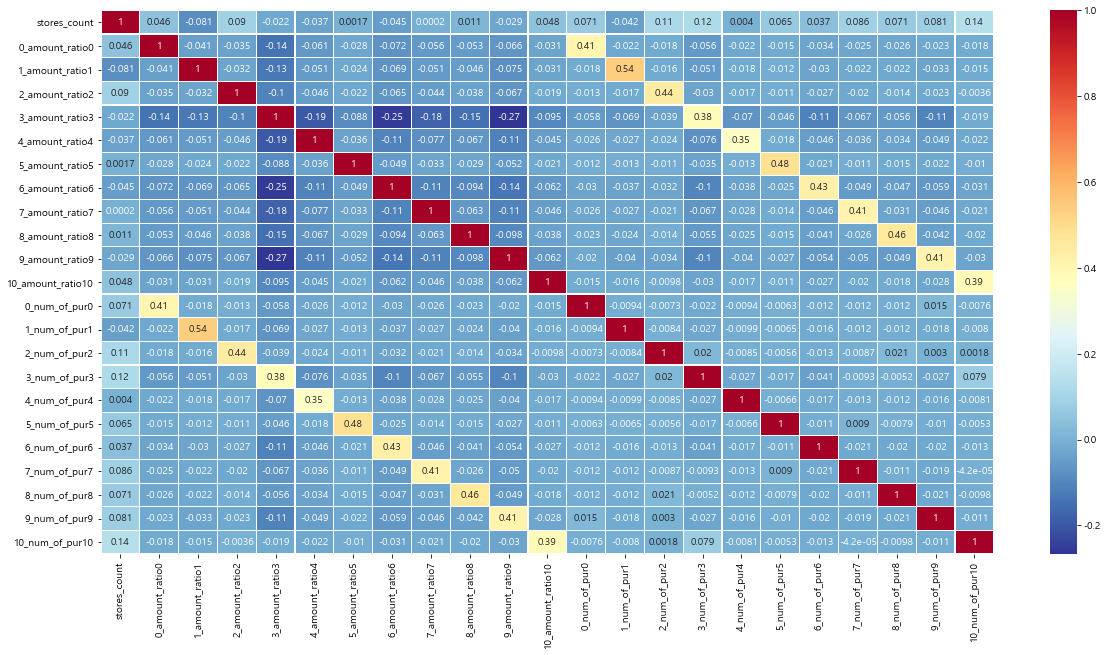

In [123]:
plt.figure(figsize=(20,10))
sns.heatmap(store_df.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.2)
plt.show()

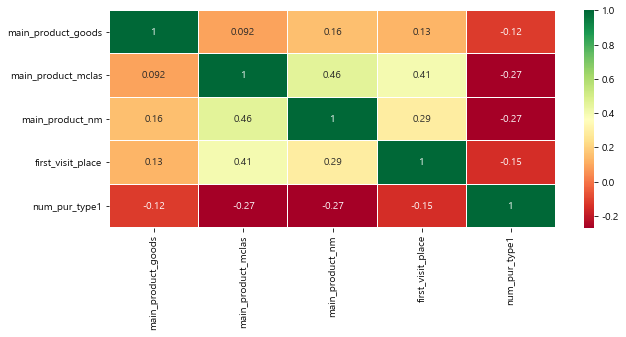

In [124]:
plt.figure(figsize=(10,4))
sns.heatmap(product_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

<font color = 'blue'> 모든 피쳐끼리 상관관계
    - 모든 피쳐중 높은 상관관계를 갖는 것으로 보이는 칼럼 중 3개 칼럼 제거
    - 밑의 히트맵은 상관관계가 높았던 칼럼이 있던 모습이었음.
    - 3개 칼럼 제거이후 1000개가 넘는 피쳐끼리 상관관계가 0.7이상으로 높은 피쳐는 없었음

In [125]:
df3 = df2.drop(columns=['purchase_count','total_visit2','6_num_of_pur6'])

In [126]:
corrdf = (df2.corr() >= 0.7).sum().reset_index().rename(columns={'index':'cols',0:'corrCount'})

corrlst = corrdf.query('corrCount > 1')['cols'].unique().tolist()

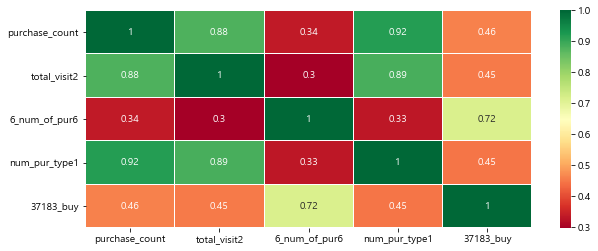

In [127]:
plt.figure(figsize=(10,4))
sns.heatmap(df2[corrlst].corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

<br><font color='green'>
## ch.3 modeling

In [233]:
X_train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('tr_train_y.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

y_train.drop(columns='cust_id', inplace=True)

### Basic models predictions with Stratied KFold

     - 9개의 모델별 피쳐에 대한 기본적인 성능을 확인한다
     - 불균형 데이터이기 때문에 기본적으로 모델 모두 Stratied KFold로 학습시켜보았다
     - 기본적인 성능확인 후 훈련점수가 0.6조차 되지 않는 SVM인 SVC과 neural network인 mlp는 튜닝하지 않기로 하였고
        또한 앙상블 할때 유의할점인 모델간 유사성능을 생각해서 knn와 logreg또한 튜닝대상에서 제외하였다

In [129]:
rf = RandomForestClassifier()
extra = ExtraTreesClassifier()
knn = KNeighborsClassifier()
logreg = LogisticRegression()
svm = SVC()
gbm = GradientBoostingClassifier()
lgbm = LGBMClassifier()
xgb = XGBClassifier()
mlp = MLPClassifier()

models = [rf, extra, knn, logreg, svm, gbm, lgbm, xgb, mlp]

In [130]:
# 모델별로 총 12개의 모델을 평균내어 예측한다


for model in models:
    
    lucky_seed = [2533,5066,9538]
    
    cv_scores = []
    
    for rs in lucky_seed:
        
        skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=rs)
        
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv = skf)
        
        cv_scores.append(scores)
        
    print(f'{model.__class__.__name__}, \ncv성능들: {cv_scores}\n최고성능: {max([score for scoreArr in cv_scores for score in scoreArr])}\n평균성능: {np.mean(cv_scores)}\n')

RandomForestClassifier, 
cv성능들: [array([0.73135097, 0.74584711, 0.7570755 , 0.75184264]), array([0.72808878, 0.73529232, 0.76617734, 0.74019395]), array([0.72994812, 0.7410596 , 0.75494895, 0.74365098])]
최고성능: 0.7661773383657883
평균성능: 0.7437896871787449

ExtraTreesClassifier, 
cv성능들: [array([0.73545376, 0.7300344 , 0.74130454, 0.7449759 ]), array([0.72824187, 0.73468831, 0.74581093, 0.74230936]), array([0.73334391, 0.73308227, 0.74105682, 0.74934311])]
최고성능: 0.7493431087656014
평균성능: 0.7383037639496606

KNeighborsClassifier, 
cv성능들: [array([0.59620673, 0.59760402, 0.61246201, 0.60452086]), array([0.59620673, 0.59760402, 0.61246201, 0.60452086]), array([0.59620673, 0.59760402, 0.61246201, 0.60452086])]
최고성능: 0.6124620060790273
평균성능: 0.6026984034202879

LogisticRegression, 
cv성능들: [array([0.61468319, 0.63398354, 0.64344166, 0.62414131]), array([0.61468319, 0.63398354, 0.64344166, 0.62414131]), array([0.61468319, 0.63398354, 0.64344166, 0.62414131])]
최고성능: 0.6434416647182605
평균성능: 0.629062

### Tuned models predictions with Stratified KFold

<font color = 'blue'> RandomSearch + Stratified KFold
 

In [131]:

lucky_seed = [2533,5066,9538]  # 각 모델별 3개의 튜닝된 모델을 뽑아낸다

clfs_tuned = []  # 튜닝된 모델을 저장

for seed in lucky_seed:
    
    clfs = [
    (RandomForestClassifier(random_state=seed, n_jobs=-1),
     {'criterion': ['gini', 'entropy'],
      'n_estimators': [50, 70, 90, 110],
      'max_depth': [3, 5, 7,10],
      'max_features': [0.8,0.85,0.9]}
    ),
    (ExtraTreesClassifier(random_state=seed, n_jobs=-1),
        {'n_estimators': [50, 75, 100, 125],
            'max_depth': [3,5,7,10],    
            'max_features': [0.8,0.9,0.95],
            'min_samples_split': [2,3,5],
            'min_samples_leaf': [1,3,5]}
    ),
    (GradientBoostingClassifier(random_state=seed),
        {'learning_rate': [0.01, 0.5, 1.0, 2.0],
         'n_estimators' : [100,125,150,175,200],
         'max_depth' : [3,4,5,6,7],
         'min_samples_split' : [0.75, 0.9],
         'subsample' : [0.8,0.9,0.95]}
    ),
    (LGBMClassifier(random_state=seed, objective='binary', n_jobs=-1),
        {'learning_rate': np.arange(0.1, 0.6, 0.1),
         'n_estimators': [100,125,150,175,200],
         'max_depth': [3,5,7,9],
         'min_child_weight': [3,8,13],
         'subsample': [0.75,0.85,0.95]}
    ),
    (XGBClassifier(random_state=seed, n_jobs=-1),
        {'learning_rate': [0.05,0.35,0.65,1.0],
         'n_estimators': [100,125,150,175,200],
         'max_depth': [3,5,7,9],
         'min_child_weight': [3,8,13],
         'subsample': [0.75, 0.85, 0.95],
         'gamma': [0,2,4],}
    )
    ]
    
    
    for clf, param_grid in tqdm(clfs):
    
        # 파라미터 서치
        rs = RandomizedSearchCV(clf, param_distributions = param_grid, scoring='roc_auc', random_state=seed, n_jobs=-1)

        # 모델 훈련
        scores = cross_val_score(rs, X_train, y_train, scoring='roc_auc', cv = 4, n_jobs=-1)

        # 모델 이름
        clf_name = type(clf).__name__
    
        # 모델 성능저장
        clf_score = max(scores)
    
        # 모델, 모델성능 확인
        print(f'모델: {clf_name:30} 성능: {clf_score}')
    
        # 튜닝된 모델을 튜닝된 모델 리스트에 추가
        clfs_tuned.append((clf_name, rs, clf_score))


 20%|████████████████▌                                                                  | 1/5 [04:54<19:37, 294.27s/it]

모델: RandomForestClassifier         성능: 0.7436342785886859


 40%|█████████████████████████████████▏                                                 | 2/5 [07:12<12:22, 247.60s/it]

모델: ExtraTreesClassifier           성능: 0.745276506674683


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:30<08:21, 250.70s/it]

모델: GradientBoostingClassifier     성능: 0.741883496442767


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [12:30<03:13, 193.30s/it]

모델: LGBMClassifier                 성능: 0.757910529187125


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

모델: XGBClassifier                  성능: 0.7613759087923222


 20%|████████████████▌                                                                  | 1/5 [04:54<19:37, 294.26s/it]

모델: RandomForestClassifier         성능: 0.7500361846866406


 40%|█████████████████████████████████▏                                                 | 2/5 [08:09<13:13, 264.44s/it]

모델: ExtraTreesClassifier           성능: 0.7464873019584266


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:44<08:19, 249.60s/it]

모델: GradientBoostingClassifier     성능: 0.745666187915428


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [12:49<03:14, 194.31s/it]

모델: LGBMClassifier                 성능: 0.7494544462629569


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

모델: XGBClassifier                  성능: 0.765712504314328


 20%|████████████████▌                                                                  | 1/5 [05:37<22:30, 337.55s/it]

모델: RandomForestClassifier         성능: 0.7467238941403076


 40%|█████████████████████████████████▏                                                 | 2/5 [08:16<14:11, 283.86s/it]

모델: ExtraTreesClassifier           성능: 0.7427602792344433


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:48<08:44, 262.49s/it]

모델: GradientBoostingClassifier     성능: 0.5


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [13:03<03:26, 206.14s/it]

모델: LGBMClassifier                 성능: 0.7494544462629569


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [32:14<00:00, 386.89s/it]

모델: XGBClassifier                  성능: 0.7627509268846655


<font color = 'blue'> BaysianOptimization + Stratified KFold
 

In [132]:
BO_tuned_clfs = []

RF

In [133]:
# 하이퍼 파라미터 범위

pbounds = { 'n_estimators': (50,250),
            'max_depth': (3,10), # 나무의 범위를 넓게 주었기에 과적합을 막고자 깊이를 10이상으론 올라가지 않도록 하였다
            'max_features': (0.8,0.95),
            'min_samples_leaf': (1, 10)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    
    params = {
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }

    rf = RandomForestClassifier(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)

In [134]:
BO_rf.maximize(init_points=15, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7351   |  6.842    |  0.9073   |  6.425    |  159.0    |
|  2        |  0.7299   |  5.966    |  0.8969   |  4.938    |  228.4    |
|  3        |  0.7413   |  9.746    |  0.8575   |  8.126    |  155.8    |
|  4        |  0.7343   |  6.976    |  0.9388   |  1.639    |  67.43    |
|  5        |  0.7072   |  3.142    |  0.9249   |  8.003    |  224.0    |
|  6        |  0.7434   |  9.85     |  0.9199   |  5.153    |  206.1    |
|  7        |  0.7178   |  3.828    |  0.896    |  2.29     |  238.9    |
|  8        |  0.7355   |  6.653    |  0.8622   |  3.381    |  204.8    |
|  9        |  0.7314   |  6.193    |  0.8853   |  1.169    |  173.5    |
|  10       |  0.7341   |  7.285    |  0.8925   |  9.494    |  186.4    |
|  11       |  0.7288   |  5.517    |  0.8656   |  7.279    |  62.05    |
|  12       |  0.7372   |  7.667    | 

In [135]:
# BO_rf.res  # 모든 성능 들어가있음
BO_rf.max

{'target': 0.7440504024850529,
 'params': {'max_depth': 9.933278993630882,
  'max_features': 0.8078216468158051,
  'min_samples_leaf': 1.2303522534421372,
  'n_estimators': 216.8513552784347}}

In [136]:
max_params = BO_rf.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))

max_params

{'max_depth': 10,
 'max_features': 0.8078216468158051,
 'min_samples_leaf': 1,
 'n_estimators': 217}

In [137]:
rf_clf = RandomForestClassifier(**max_params,  n_jobs=-1, random_state=42)

scores = cross_val_score(rf_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((rf_clf.__class__.__name__, rf_clf, max(scores)))

[0.72499081 0.73625817 0.73872429 0.73577942]
최대성능: 0.738724294955298
평균성능: 0.7339381742877183


XGB

In [138]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95),  
            'colsample': (0.7,0.9),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample,   
        'gamma': gamma,
        'n_jobs' : -1
    }
    
    xgb = XGBClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [139]:
BO_xgb.maximize(init_points=15, n_iter=20)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.687    |  0.8098   |  3.576    |  0.924    |  6.814    |  134.7    |  0.8969   |
|  2        |  0.6607   |  0.7875   |  4.459    |  1.447    |  5.684    |  208.3    |  0.8793   |
|  3        |  0.7437   |  0.8136   |  4.628    |  0.153    |  3.61     |  54.04    |  0.9249   |
|  4        |  0.6797   |  0.8556   |  4.35     |  1.469    |  8.594    |  142.3    |  0.9171   |
|  5        |  0.7229   |  0.7237   |  3.2      |  0.2579   |  9.613    |  154.4    |  0.8622   |
|  6        |  0.7067   |  0.7529   |  3.871    |  0.7114   |  6.979    |  53.76    |  0.8926   |
|  7        |  0.664    |  0.8224   |  3.085    |  1.418    |  7.773    |  121.9    |  0.8656   |
|  8        |  0.6864   |  0.8395   |  0.3011   |  1.017    |  7.694    |  92.08    |  0.8193   |
|  9        |  0.686

In [140]:
# BO_rf.res  # 모든 성능 들어가있음
BO_xgb.max

{'target': 0.7486632541723727,
 'params': {'colsample': 0.8548781179307093,
  'gamma': 3.951962120990985,
  'learning_rate': 0.10771697765265095,
  'max_depth': 3.381508388534084,
  'n_estimators': 59.92425445048091,
  'subsample': 0.821324376341919}}

In [141]:
max_params = BO_xgb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))

max_params

{'colsample': 0.8548781179307093,
 'gamma': 3.951962120990985,
 'learning_rate': 0.10771697765265095,
 'max_depth': 3,
 'n_estimators': 60,
 'subsample': 0.821324376341919}

In [142]:
xgb_clf = XGBClassifier(**max_params)

scores = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((xgb_clf.__class__.__name__, xgb_clf, max(scores)))

[0.73385885 0.74512342 0.76553158 0.75013917]
최대성능: 0.7655315808811249
평균성능: 0.7486632541723727


LGBM

In [143]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    


In [144]:
BO_lgbm.maximize(init_points=15, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7003   |  0.8126   |  1.094    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.7135   |  0.8018   |  0.6253   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.6975   |  0.7541   |  1.022    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7245   |  0.8952   |  0.5045   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.6757   |  0.7755   |  1.323    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.6961   |  0.7973   |  1.045    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.696    |  0.7921   |  1.194    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

In [145]:
# BO_rf.res  # 모든 성능 들어가있음
BO_lgbm.max

{'target': 0.7478045637240167,
 'params': {'colsample_bytree': 0.8990715881548663,
  'learning_rate': 0.05,
  'max_depth': 10.0,
  'min_child_weight': 1.0,
  'n_estimators': 136.75237845794302,
  'num_leaves': 8.880048094469647,
  'subsample': 0.8000000102710303}}

In [146]:
max_params = BO_lgbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.8990715881548663,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 1.0,
 'n_estimators': 137,
 'num_leaves': 9,
 'subsample': 0.8000000102710303}

In [147]:
lgbm_clf = LGBMClassifier(**max_params)

scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((lgbm_clf.__class__.__name__, lgbm_clf, max(scores)))

[0.73915294 0.73978757 0.76511963 0.74715811]
최대성능: 0.7651196321409088
평균성능: 0.7478045637240167


ExtraTreeClassifier

In [148]:
pbounds = { 'n_estimators': (50, 250),
            'max_depth': (3,10),    
            'max_features': (0.8,0.95),
            'min_samples_split': (2, 5),
            'min_samples_leaf': (1, 5)
            }

def extra_opt(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):

    params = {
        'n_estimators': int(round(n_estimators)),
        'max_depth': int(round(max_depth)),
        'max_features' : max_features,
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
        'n_jobs' : -1
    }
    
    extra = ExtraTreesClassifier(bootstrap = True, oob_score=True, **params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(extra, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_extra = BayesianOptimization(f = extra_opt, pbounds = pbounds, random_state=0)    



In [149]:
BO_extra.maximize(init_points=15, n_iter=20)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.7371   |  6.842    |  0.9073   |  3.411    |  3.635    |  134.7    |
|  2        |  0.7401   |  7.521    |  0.8656   |  4.567    |  4.891    |  126.7    |
|  3        |  0.7392   |  8.542    |  0.8793   |  3.272    |  4.777    |  64.21    |
|  4        |  0.7332   |  3.61     |  0.803    |  4.33     |  4.334    |  224.0    |
|  5        |  0.7373   |  9.85     |  0.9199   |  2.846    |  4.342    |  73.65    |
|  6        |  0.7401   |  7.479    |  0.8215   |  4.779    |  3.566    |  132.9    |
|  7        |  0.7357   |  4.852    |  0.9161   |  2.825    |  3.705    |  53.76    |
|  8        |  0.7422   |  7.323    |  0.8918   |  3.468    |  4.831    |  186.4    |
|  9        |  0.7386   |  5.517    |  0.8656   |  3.791    |  2.181    |  183.4    |
|  10       |  0.7406   |  7.694    |  0.8316   |  1.5

In [150]:
# BO_rf.res  # 모든 성능 들어가있음
BO_extra.max

{'target': 0.7454699555763384,
 'params': {'max_depth': 9.863393737026527,
  'max_features': 0.8294853548465777,
  'min_samples_leaf': 4.890311444140735,
  'min_samples_split': 2.277517807483899,
  'n_estimators': 165.7061462278227}}

In [151]:
max_params = BO_extra.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

{'max_depth': 10,
 'max_features': 0.8294853548465777,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 166}

In [152]:
extra_clf = ExtraTreesClassifier(bootstrap = True, oob_score=True, **max_params)

scores = cross_val_score(extra_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((extra_clf.__class__.__name__, extra_clf, max(scores)))

[0.73101417 0.74456951 0.75585357 0.74091764]
최대성능: 0.7558535689234777
평균성능: 0.7430887248516428


GBM

In [153]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}


def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(gbm, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    


In [154]:
BO_gbm.maximize(init_points=15, n_iter=20)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.6862   |  0.8458   |  8.006    |  3.411    |  3.635    |  134.7    |  0.8969   |
|  2        |  0.7021   |  0.6845   |  9.242    |  4.855    |  3.15     |  208.3    |  0.8793   |
|  3        |  0.6704   |  0.8737   |  9.479    |  1.284    |  2.261    |  54.04    |  0.9249   |
|  4        |  0.6436   |  1.178    |  9.09     |  4.914    |  4.397    |  142.3    |  0.9171   |
|  5        |  0.7165   |  0.2215   |  7.479    |  1.573    |  4.834    |  154.4    |  0.8622   |
|  6        |  0.7096   |  0.4336   |  8.42     |  2.825    |  3.705    |  53.76    |  0.8926   |
|  7        |  0.6776   |  0.9375   |  7.319    |  4.775    |  4.045    |  121.9    |  0.8656   |
|  8        |  0.6615   |  1.062    |  3.422    |  3.667    |  4.012    |  92.08    |  0.8193   |
|  9        |  0.696

In [155]:
# BO_rf.res  # 모든 성능 들어가있음
BO_gbm.max

{'target': 0.7489930915082891,
 'params': {'learning_rate': 0.05,
  'max_depth': 3.0,
  'min_samples_leaf': 1.0,
  'min_samples_split': 2.0,
  'n_estimators': 122.00588046248643,
  'subsample': 0.8157498187965457}}

In [156]:
max_params = BO_gbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 122,
 'subsample': 0.8157498187965457}

In [157]:
gbm_clf = GradientBoostingClassifier(**max_params)

scores = cross_val_score(gbm_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((gbm_clf.__class__.__name__, gbm_clf, max(scores)))

[0.734371   0.73762484 0.76090829 0.74657081]
최대성능: 0.7609082913034281
평균성능: 0.7448687330906176


### RandomSearchCV -> Ensemble: Voting(soft), Stacking

<font color = 'blue'> select_models

 -  RandomSearchCV에서 모델별 튜닝된 모델이 3개이므로 각 모델별 중 가장 점수가 좋은 모델을 선택하였다

In [158]:
# 각 모델별 제일 점수 높은 점수 선택
rf_max = max([clf[2] for clf in clfs_tuned if clf[0] == 'RandomForestClassifier'])
extra_max = max([clf[2] for clf in clfs_tuned if clf[0] == 'ExtraTreesClassifier'])
gbm_max = max([clf[2] for clf in clfs_tuned if clf[0] == 'GradientBoostingClassifier'])
lgbm_max = max([clf[2] for clf in clfs_tuned if clf[0] == 'LGBMClassifier'])
xgb_max = max([clf[2] for clf in clfs_tuned if clf[0] == 'XGBClassifier'])

max_scores = [rf_max, extra_max, gbm_max, lgbm_max, xgb_max]

# 각 모델별 제일 높은 점수를 가진 모델 선택
selected_models = [clf for score in max_scores for clf in clfs_tuned if clf[2] == score]

<font color = 'blue'> Voting(soft)

In [247]:
estimators = [(clf[0], clf[1]) for clf in selected_models if clf[0] in ['ExtraTreesClassifier','LGBMClassifier','XGBClassifier']]

ensemble_softVoting = VotingClassifier(estimators = estimators, voting='soft', n_jobs=-1)

In [160]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

print('앙상블 성능:', np.mean(cross_val_score(ensemble_softVoting, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)))

앙상블 성능: 0.7499241513299264


In [161]:
ensemble_softVoting.fit(X_train,y_train)

pred_RS_voting = ensemble_softVoting.predict_proba(X_test)[:,1]

In [162]:
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred_RS_voting}).set_index('cust_id').to_csv('submission_RS_Voting.csv', index=False, encoding='cp949')

<font color = 'blue'> Stacking

    - 스태킹과정:
        1. 랜덤서치 혹은 베이지안 최적화 이후 최적모델 3개로 stacktransform
        2. 메타모델 LGBM을 베이지안 최적화로 튜닝 
        3. 메타모델을 cross_val_score로 점수측정

In [252]:
stack_estimators = [estimators[i][1].estimator for i in range(len(estimators))]

    - S_train, S_test transform

In [255]:
S_train, S_test = stacking(stack_estimators,
                           X_train, y_train, X_test,
                           regression=False, needs_proba=True, metric=None, n_folds=4, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

    - Meta_model최적화: BaysianOptimization + Stratified KFold
 

In [256]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def meta_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    meta_model = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

    score = cross_val_score(meta_model, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

RS_meta = BayesianOptimization(f = meta_opt, pbounds = pbounds, random_state=1)

In [257]:
RS_meta.maximize(init_points=25, n_iter=25)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7027   |  0.8126   |  1.083    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.6933   |  0.8018   |  0.6012   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.6963   |  0.7541   |  1.009    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.718    |  0.8952   |  0.477    |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.655    |  0.7755   |  1.318    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.6509   |  0.7973   |  1.033    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.6574   |  0.7921   |  1.186    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

|  45       |  0.7409   |  0.7861   |  0.0133   |  9.831    |  5.283    |  134.3    |  2.265    |  0.9188   |
|  46       |  0.7387   |  0.811    |  0.0681   |  3.832    |  4.824    |  207.3    |  2.556    |  0.8691   |
|  47       |  0.7444   |  0.78     |  0.07558  |  9.664    |  6.072    |  55.02    |  3.707    |  0.914    |
|  48       |  0.7441   |  0.8038   |  0.06456  |  4.173    |  5.785    |  60.27    |  2.053    |  0.8304   |
|  49       |  0.7443   |  0.7577   |  0.03964  |  4.171    |  1.244    |  91.38    |  2.28     |  0.9331   |
|  50       |  0.739    |  0.75     |  0.01     |  3.0      |  1.0      |  134.1    |  2.0      |  0.8      |


In [258]:
# RS_meta.res  # 모든 성능 들어가있음
RS_meta.max

{'target': 0.7448791709809947,
 'params': {'colsample_bytree': 0.8026501694496496,
  'learning_rate': 0.1141881343733905,
  'max_depth': 9.246209006847955,
  'min_child_weight': 5.704923889210633,
  'n_estimators': 64.2264432132875,
  'num_leaves': 2.166964053186976,
  'subsample': 0.8002582302584448}}

In [259]:
max_params = RS_meta.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.8026501694496496,
 'learning_rate': 0.1141881343733905,
 'max_depth': 9,
 'min_child_weight': 5.704923889210633,
 'n_estimators': 64,
 'num_leaves': 2,
 'subsample': 0.8002582302584448}

    - 메타 모델 최적화 이후 성능

In [260]:
meta_clf = LGBMClassifier(**max_params)

skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

scores = cross_val_score(meta_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.74289667 0.74315831 0.74592783 0.74164969]
최대성능: 0.7459278310342141
평균성능: 0.7434081242971821


In [261]:
meta_clf.fit(S_train, y_train)

pred = meta_clf.predict_proba(S_test)[:,1]

pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_RS_stack.csv', index=False, encoding='cp949')

### BaysianOptimization -> Ensemble: Voting(soft), Stacking

<font color = 'blue'> Voting(soft)

In [262]:
estimators = [(clf[0],clf[1]) for clf in BO_tuned_clfs if clf[0] in ['ExtraTreesClassifier','LGBMClassifier','XGBClassifier']]

ensemble_softVoting = VotingClassifier(estimators = estimators, voting='soft', n_jobs=-1)

In [167]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

print('앙상블 성능:', np.mean(cross_val_score(ensemble_softVoting, X_train, y_train, cv=skf, n_jobs=-1)))

앙상블 성능: 0.6968571428571427


In [168]:
ensemble_softVoting.fit(X_train,y_train)

pred_BO_voting = ensemble_softVoting.predict_proba(X_test)[:,1]

In [169]:
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred_BO_voting}).set_index('cust_id').to_csv('submission_BO_Voting.csv', index=False, encoding='cp949')

<font color = 'blue'> Stacking


In [266]:
stack_estimators = [estimators[i][1] for i in range(len(estimators))]

    - S_train, S_test transform

In [268]:
S_train, S_test = stacking(stack_estimators,
                           X_train, y_train, X_test,
                           regression=False, needs_proba=True, metric=None, n_folds=4, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

    - Meta_model최적화: BaysianOptimization + Stratified KFold
 

In [269]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def meta_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    meta_model = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

    score = cross_val_score(meta_model, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_meta = BayesianOptimization(f = meta_opt, pbounds = pbounds, random_state=1)

In [270]:
BO_meta.maximize(init_points=25, n_iter=25)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7143   |  0.8126   |  1.083    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.7164   |  0.8018   |  0.6012   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.705    |  0.7541   |  1.009    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.7259   |  0.8952   |  0.477    |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.672    |  0.7755   |  1.318    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.657    |  0.7973   |  1.033    |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.6925   |  0.7921   |  1.186    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

|  45       |  0.7446   |  0.7935   |  0.04652  |  9.703    |  1.374    |  124.6    |  9.391    |  0.87     |
|  46       |  0.7469   |  0.7992   |  0.07872  |  3.147    |  1.307    |  94.01    |  3.67     |  0.9447   |
|  47       |  0.7482   |  0.8888   |  0.01661  |  3.322    |  5.248    |  190.6    |  2.515    |  0.8081   |
|  48       |  0.7269   |  0.75     |  0.01     |  3.0      |  2.236    |  75.22    |  2.0      |  0.8      |
|  49       |  0.7466   |  0.804    |  0.06276  |  9.717    |  6.543    |  111.3    |  3.419    |  0.885    |
|  50       |  0.7463   |  0.8123   |  0.1835   |  4.544    |  6.892    |  213.0    |  2.313    |  0.8171   |


In [271]:
# BO_rf.res  # 모든 성능 들어가있음
BO_meta.max

{'target': 0.7485755758932051,
 'params': {'colsample_bytree': 0.7964280610284445,
  'learning_rate': 0.06584944688550372,
  'max_depth': 9.315555002753468,
  'min_child_weight': 1.0919006577210602,
  'n_estimators': 88.46088403981594,
  'num_leaves': 2.31300150657957,
  'subsample': 0.9309987565858551}}

In [272]:
max_params = BO_meta.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.7964280610284445,
 'learning_rate': 0.06584944688550372,
 'max_depth': 9,
 'min_child_weight': 1.0919006577210602,
 'n_estimators': 88,
 'num_leaves': 2,
 'subsample': 0.9309987565858551}

    - 메타 모델 최적화 이후 성능

In [273]:
meta_clf = LGBMClassifier(**max_params)

skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=1)

scores = cross_val_score(meta_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.74036096 0.74188906 0.73806462 0.7387911 ]
최대성능: 0.7418890633176347
평균성능: 0.7397764343053097


In [274]:
meta_clf.fit(S_train, y_train)

pred = meta_clf.predict_proba(S_test)[:,1]

pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':pred}).set_index('cust_id').to_csv('submission_BO_stack.csv', index=False, encoding='cp949')

### Best of bests

In [275]:
# 튜닝된 모든 모델을 분류
all_tuned_clfs = clfs_tuned + BO_tuned_clfs

tree_tuned_clfs = [(clf[1],clf[2]) for clf in all_tuned_clfs if clf[0] in ['ExtraTreesClassifier','RandomForestClassifier']]

boost_tuned_clfs = [(clf[1],clf[2]) for clf in all_tuned_clfs if clf[0] in ['LGBMClassifier','XGBClassifier','GradientBoostingClassifier']]

# 각 알고리즘 모델별 최고점수
max_tree_score = max([clf[1] for clf in tree_tuned_clfs])

max_boost_score = max([clf[1] for clf in boost_tuned_clfs])

# 나무기반 최고모델, 부스팅기반 최고모델 뽑아내기
for clf in tree_tuned_clfs:
    
    if clf[1] == max_tree_score:
        
        best_tree = clf[0]
for clf in boost_tuned_clfs:
    
    if clf[1] == max_boost_score:
        
        best_boost = clf[0]

In [204]:
X_train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y = pd.read_csv('tr_train_y.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

y.drop(columns='cust_id', inplace=True)

In [216]:
# best_tree

# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

lucky_seed=[2533,5066,9538]

pred_probas_tree = []

for num,rs in enumerate(lucky_seed):
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=rs)
    
    for n, (train_idx, validation_idx) in enumerate(skf.split(X_train,y)):
        
        x_train, x_validation = X_train.iloc[train_idx], X_train.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        
        best_tree.random_state=rs
        
        model = best_tree
        
        pred = model.fit(x_train, y_train).predict_proba(x_validation)[:,1]
        
        print(roc_auc_score(y_validation, pred))
        
        pred_probas_tree.append(model.predict_proba(X_test)[:,1])

0.7347217119253594
0.7427324448601044
0.7569057082734894
0.7382177093423294
0.7373993787367649
0.7416803055100928
0.7564659251589342
0.7411347517730498
0.7414297961410424
0.7409621786521482
0.7599674894507721
0.7400325105492278


In [217]:
# best_boost

# 4FOLD, 3SEED ENSEMBLE
# 총 12개의 모델을 평균내어 예측한다

lucky_seed=[2533,5066,9538]

pred_probas_boost = []

for num,rs in enumerate(lucky_seed):
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=rs)
    
    for n, (train_idx, validation_idx) in enumerate(skf.split(X_train,y)):
        
        x_train, x_validation = X_train.iloc[train_idx], X_train.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
        
        best_boost.random_state=rs
        
        model = best_boost
        
        model.fit(x_train, y_train, eval_set=[(x_validation, y_validation)], early_stopping_rounds=30, verbose=20)
        
        pred = model.predict_proba(x_validation)[:,1]
        
        print(roc_auc_score(y_validation, pred))
        
        pred_probas_boost.append(model.predict_proba(X_test)[:,1])

[0]	validation_0-error:0.33714
Will train until validation_0-error hasn't improved in 30 rounds.
[20]	validation_0-error:0.32914
[40]	validation_0-error:0.32000
Stopping. Best iteration:
[10]	validation_0-error:0.31429

0.7078003050647428
[0]	validation_0-error:0.32457
Will train until validation_0-error hasn't improved in 30 rounds.
[20]	validation_0-error:0.30057
[40]	validation_0-error:0.29371
[60]	validation_0-error:0.29714
Stopping. Best iteration:
[47]	validation_0-error:0.28800

0.7367647550018371
[0]	validation_0-error:0.30743
Will train until validation_0-error hasn't improved in 30 rounds.
[20]	validation_0-error:0.29371
[40]	validation_0-error:0.29143
[60]	validation_0-error:0.29829
Stopping. Best iteration:
[42]	validation_0-error:0.28914

0.7533874433570482
[0]	validation_0-error:0.36229
Will train until validation_0-error hasn't improved in 30 rounds.
[20]	validation_0-error:0.33143
[40]	validation_0-error:0.32686
[60]	validation_0-error:0.31657
[80]	validation_0-error:0.

In [218]:
# 교차검증 12개의 모델 점수 평균

tree_prediction = np.zeros(2482)

for proba in pred_probas_tree:
    
    tree_prediction += proba/12

boost_prediction = np.zeros(2482)

for proba in pred_probas_boost:
    
    boost_prediction += proba/12
    
# 평균낸 점수 앙상블: best_tree_prediction : best_boost_prediction = 1 : 2 로 하였음

best_models_prediction = np.zeros(2482)

best_models_prediction = tree_prediction / 3 + boost_prediction / 3 * 2

In [219]:
pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':best_models_prediction}).set_index('cust_id').to_csv('submission_SeedEnsemble.csv', index=False, encoding='cp949')

# End

## 상품군미지정에 대한 조사
 - 중분류가 '상품군미지정'인 상품들
 - 대분류가 '기타'로 해당되어 있다
 - 이 물품은 특정 분야가 없이 모든 여러 제품들과 함께 지급되는 모양이다.
 - 마치 서비스 물품이나, 행사제품, 기타 제품으로써 특정 물품이 팔릴때 같이 팔리는 것 같다
 
 ### 문제제기
####  - 이 '상품군미지정'이란 제품이 남,여를 구별하는데 방해할 것 같다.           


      * 왜? 사람들은 '상품군미지정'을 사기 위해서 물건을 사는게 아니라       
          원래 다른 물건을 사는데 이것이 데이터로써 같이 저장되서 혼란을 야기하는 것같다.
      * 즉, 데이터분석시 '본 물품' 대신에 '같이 딸려오는 물품'이 명확한 '중분류나, 대분류'없이 중복되어 기록되니      
          제품을 많이 사면 살수록 가장 많이 산 제품이 '상품군미지정'제품 = '기타'제품인것은 당연하다
          
 ### 고려할 점
 - 남,여 등 분석을 위해서는 '상품군미지정'을 드랍시키는 것이 맞지 않을까 싶다.
 - 하지만 마케팅이란 것이 '서비스물품'을 같이 팔아 매출을 올리기도 하니 생각을 해봐야 할 것 같다.       
    왜냐하면 실제로 저 같이 따라오는 '상품군미지정' 제품때문에 본 제품을 살수도 있으니 말이다.
    
    
 ### 시도해볼만한 방안
 - train과 test 데이터 모두 대분류명'기타'를 없앤다
 - '기타'에 해당하는 모든 중분류명 '상품군미지정'을 각각의 '원 제품'의 카테고리로 대분류명을 바꿔준다.
 - '상품군미지정'이라는 이름은 '서비스 및 기타'로 바꾼다.
     * 근데 이거는 머신러닝을 돌렸을 때 유의미한 결과가 나와야 함.
     * 유의미한 결과가 안나오면 모두 포기하고 처음으로 되돌아간다.

In [5]:
import pandas as pd
import numpy as np

In [17]:
sub = pd.read_csv('장성민-submit.csv', encoding='cp949')

In [6]:
sub['cust_id'] = np.arange(3500,5982)

In [14]:
sub[['cust_id', 'gender']].to_csv('장성민-submit.csv', encoding='cp949', index=False)

In [18]:
sub

,cust_id,gender
0,3500,0.791822
1,3501,0.267878
2,3502,0.233416
3,3503,0.275896
4,3504,0.459886
...,...,...
2477,5977,0.362909
2478,5978,0.459886
2479,5979,0.752219
2480,5980,0.559933
